# Introduction

Astronomy relies heavily on stellar classification to understand the Universe's composition and evolution. Traditionally, this classification involved manual analysis of stellar spectra, a time-consuming and subjective process. Machine learning offers a powerful alternative, enabling automated and objective classification with potentially higher accuracy and speed.

This project aims to leverage machine learning for multiclass classification of stars, galaxies, and quasars based on their spectral characteristics. We will use the publicly available Stellar Classification Dataset - SDSS17, containing 100,000 observations described by 17 features and labeled as belonging to one of the three classes.

## SDSS Dataset Information:

1. **Number of Observations:** 100,000
2. **Source:** Sloan Digital Sky Survey (SDSS)
3. **Data per Observation:**
    - 17 Feature Columns:
        - `obj_ID`: Unique object identifier
        - `alpha`: Right Ascension angle (J2000 epoch)
        - `delta`: Declination angle (J2000 epoch)
        - `u`, `g`, `r`, `i`, `z`: Photometric filter magnitudes
        - `run_ID`: Scan identification number
        - `rereun_ID`: Image processing details
        - `cam_col`: Scanline within the run
        - `field_ID`: Field number
        - `spec_obj_ID`: Unique ID for spectroscopic objects
        - `redshift`: Observed redshift value
        - `plate`: Plate identifier
        - `MJD`: Modified Julian Date (observation time)
        - `fiber_ID`: Fiber ID for light acquisition
    - 1 Class Column:
        - `class`: Object classification (galaxy, star, or quasar)


# Goals



1. **Develop a high-performing multiclass classification model:**
    * Train and evaluate various machine learning algorithms to determine the best model for predicting the class (star, galaxy, or quasar) of a new observation based on its spectral features.
    * Achieve high accuracy, precision, and recall for each class while minimizing misclassification.
    * Optimize the model for efficiency and speed considering future applications.

2. **Analyze and interpret the model's behavior:**
    * Identify the most important features contributing to the classification decisions.
    * Understand how the model differentiates between different classes.
    * Assess the model's limitations and potential biases.

3. **Study the resoults:**
    * Visualize the classification results: Create visualizations (e.g., confusion matrix, ROC-AUC curve) to understand the model's decision-making process and identify potential areas for improvement.





# Challenges



1. **Outliers:**
    * The dataset present a lot of outliers values, expecially in the redshift features (which is also the feature that contains most of the information) that are not erroneous measurations, which means that some objects will be missclassified if we do not address this issue properly.

2. **Complexity:**
    * The dataset contains 17 of which some of them are usless for the classification (we can say it by basic domain knowledge or by doing further nuemrical analysis), while redshift appear to have great importance, this can lead to some robustness issues

3. **Computational complexity:**
    * While SVM (support-vector-machine) appear a good candidate for further tuning, we are forced to rely on less expensive but still greatly effective models like Random Forest and XGBboost (eXtreme Gradient Boosting), which are both more effective and more easily optimizables than a SVM problem

4. **Non linearity:**
    * Most of the features do not follow a linear relation, nor are linearly separable, this force us to avoid the use of linear models but we still can try to use the "kernel trick" choosing a non-linear kernel for the SVM, to see if this will be enough to reach the perfomance of non linear classifiers

# Inititialization

In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix,multilabel_confusion_matrix,ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, QuantileTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC


from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings
import random


warnings.filterwarnings('ignore')


C:\Users\nicoc\AppData\Local\Temp\ipykernel_8340\1736260083.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#url='https://drive.google.com/file/d/1aolfsXqbQp36fVm6VPjHLbq7RQmrIIYa/view?usp=sharing'
#url='https://drive.google.com/uc?id=' + url.split('/')[-2]
star_df = pd.read_csv("star_classification_noised.csv")

# drop first column that is usless
star_df = star_df.iloc[:,1:]


# replace all the nan placeholder with nan
for col in star_df:
    star_df[col].replace({-9999: np.nan}, inplace=True)

# drop raw with all nan
star_df = star_df.dropna(how='all')

# Checking the presence and relevance of null values

In [3]:
# compute the percentage of nan in each column
star_df.isnull().sum()/len(star_df)
#star_df.isnull().sum()


obj_ID         0.00594
alpha          0.00150
delta          0.00746
u              0.00195
g              0.00042
r              0.00037
i              0.00245
z              0.00676
run_ID         0.00942
rerun_ID       0.00053
cam_col        0.00944
field_ID       0.00317
spec_obj_ID    0.00783
class          0.00000
redshift       0.00780
plate          0.00437
MJD            0.00119
fiber_ID       0.00744
dtype: float64

In [4]:
star_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 100999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       99406 non-null   float64
 1   alpha        99850 non-null   float64
 2   delta        99254 non-null   float64
 3   u            99805 non-null   float64
 4   g            99958 non-null   float64
 5   r            99963 non-null   float64
 6   i            99755 non-null   float64
 7   z            99324 non-null   float64
 8   run_ID       99058 non-null   float64
 9   rerun_ID     99947 non-null   float64
 10  cam_col      99056 non-null   float64
 11  field_ID     99683 non-null   float64
 12  spec_obj_ID  99217 non-null   float64
 13  class        100000 non-null  object 
 14  redshift     99220 non-null   float64
 15  plate        99563 non-null   float64
 16  MJD          99881 non-null   float64
 17  fiber_ID     99256 non-null   float64
dtypes: float64(17), object(1)
mem

<Axes: >

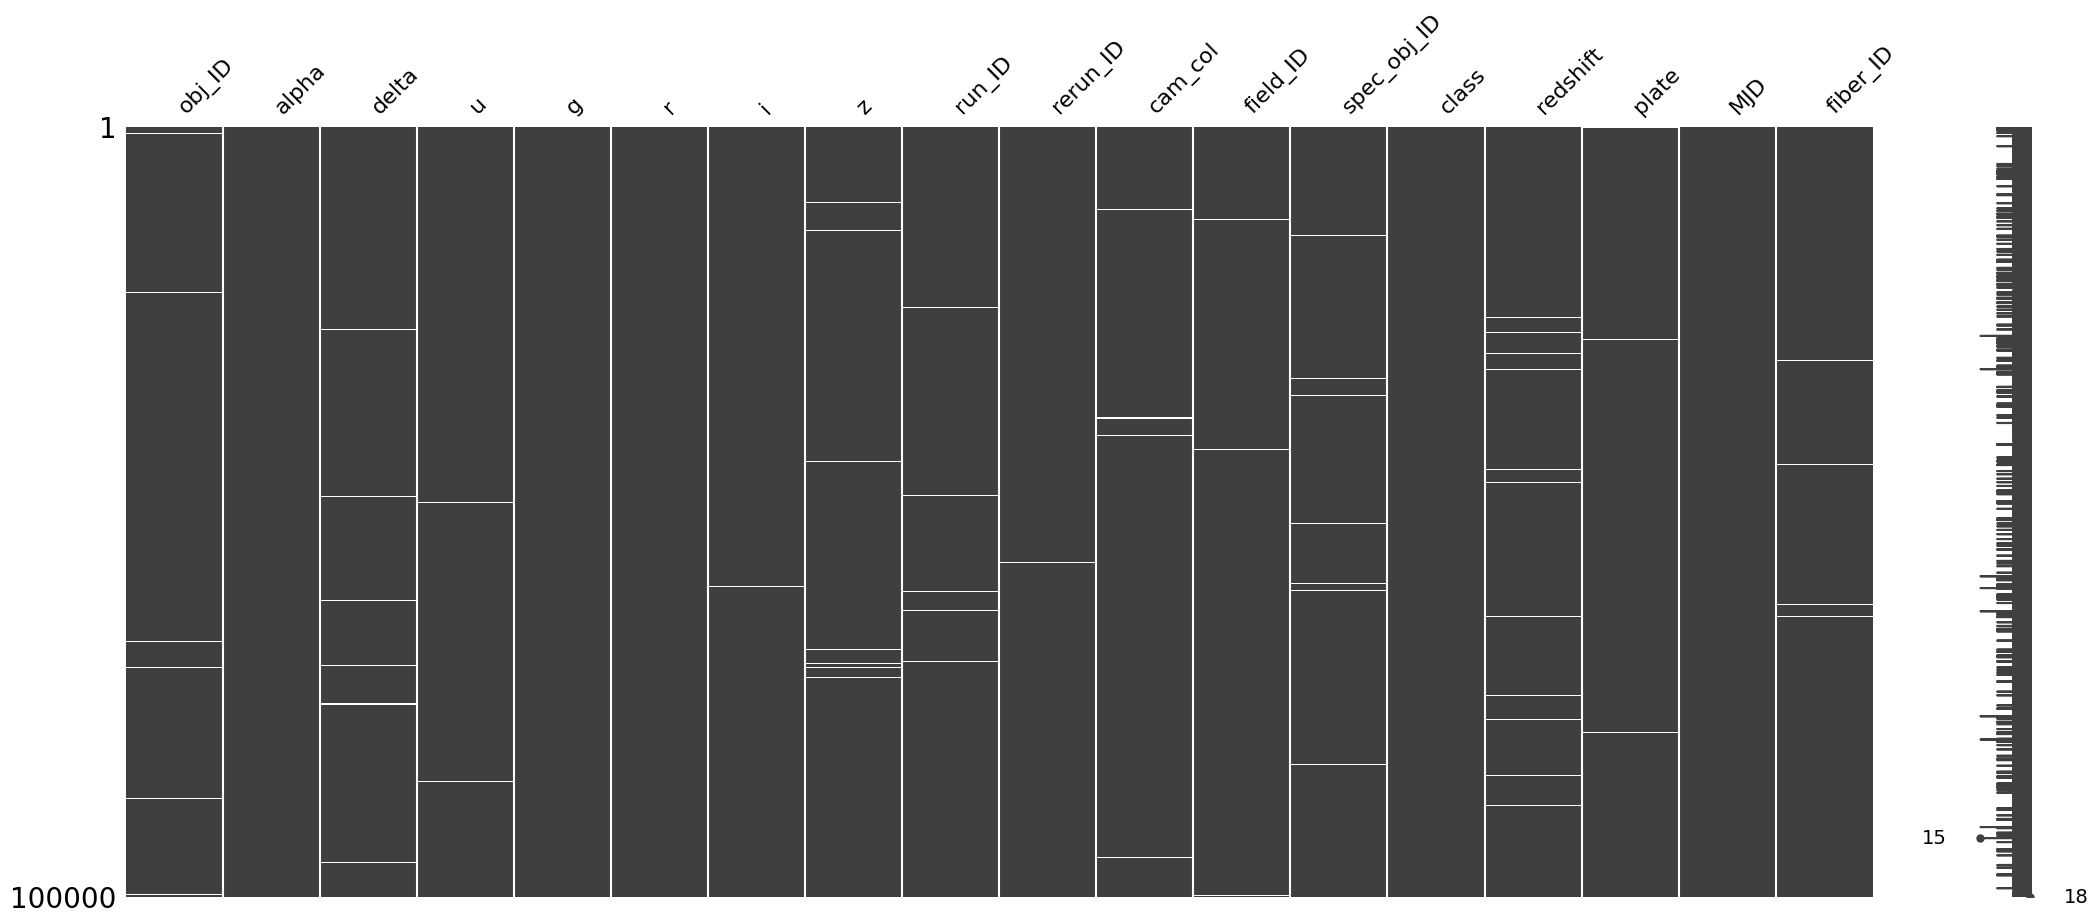

In [5]:
msno.matrix(star_df)

As we can see there are very few missing values, we can inpute them without losing any major information, probably it would be best to drop the values where the redshisft is missing since this is the most important feature, but we will try to impute them since they are few

# Exploratory data analysis

In [6]:
# puth class in the end of the df

columns =  [col for col in star_df.columns if col != "class"]
columns.append("class")
star_df = star_df.reindex(columns = columns)

In [8]:
star_df

obj_ID       alpha      delta         u         g         r  \
0       1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1       1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2       1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3       1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4       1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   
...              ...         ...        ...       ...       ...       ...   
100995  1.237679e+18   39.620709  -2.594074  22.16759  22.97586  21.90404   
100996  1.237679e+18   29.493819  19.798874  22.69118  22.38628  20.45003   
100997  1.237668e+18  224.587407  15.700707  21.16916  19.26997  18.20428   
100998  1.237661e+18  212.268621  46.660365  25.35039  21.63757  19.91386   
100999  1.237661e+18  196.896053  49.464643  22.62171  21.79745  20.60115   

               i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0       19.16573  18.79371  3606.0     301.0      2.0      79.0  6.543777e+18   
1       21.16812  21.61427  4518.0     301.0      5.0     119.0  1.176014e+19   
2            NaN  18.94827  3606.0     301.0      2.0     120.0  5.152200e+18   
3       20.50454  19.25010  4192.0     301.0      3.0     214.0  1.030107e+19   
4       15.97711  15.54461  8102.0     301.0      3.0     137.0  6.891865e+18   
...          ...       ...     ...       ...      ...       ...           ...   
100995  21.30548  20.73569  7778.0     301.0      2.0     581.0  1.055431e+19   
100996  19.75759  19.41526     NaN     301.0      1.0     289.0  8.586351e+18   
100997  17.69034  17.35221  5314.0     301.0      4.0     308.0  3.112008e+18   
100998  19.07254  18.62482  3650.0     301.0      4.0     131.0  7.601080e+18   
100999  20.00959  19.28075  3650.0     301.0      4.0      60.0  8.343152e+18   

        redshift    plate      MJD  fiber_ID   class  
0       0.634794   5812.0  56354.0     171.0  GALAXY  
1       0.779136  10445.0  58158.0     427.0  GALAXY  
2       0.644195   4576.0  55592.0     299.0  GALAXY  
3       0.932346   9149.0  58039.0     775.0  GALAXY  
4       0.116123   6121.0  56187.0     842.0  GALAXY  
...          ...      ...      ...       ...     ...  
100995  0.000000   9374.0  57749.0     438.0  GALAXY  
100996  0.404895   7626.0  56934.0     866.0  GALAXY  
100997  0.143366   2764.0  54535.0      74.0  GALAXY  
100998  0.455040   6751.0  56368.0     470.0  GALAXY  
100999  0.542944   7410.0  57104.0     851.0  GALAXY  

[100000 rows x 18 columns]

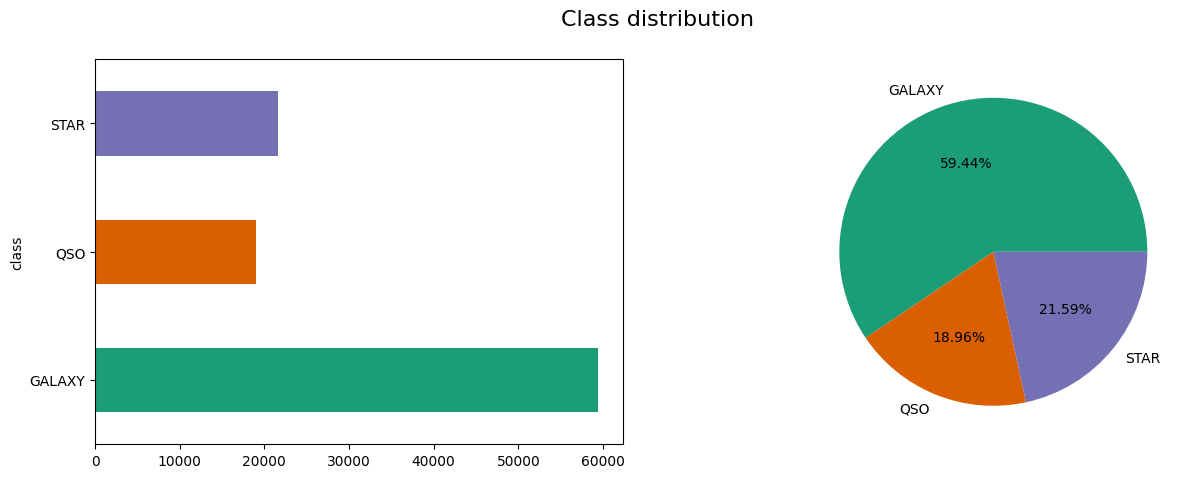

In [7]:
import seaborn as sns

# create 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Class distribution', fontsize=16)

star_df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2', n_colors=3), ax=ax[0])
plt.gca().spines[['top', 'right',]].set_visible(False)

# plot a pie chart of the class distribution, with percentage
star_df.groupby('class').size().plot(kind='pie', autopct='%.2f%%', colors=sns.palettes.mpl_palette('Dark2', n_colors=3), ax=ax[1])

plt.show()



We can see that the classes are slightly unbalanaced in favor of the "GALAXY" class. We can try to address this issues with some sampling tecnhiques like oversamplign/downsampling or with the SMOTE (Synthetic Minority Oversampling Technique)

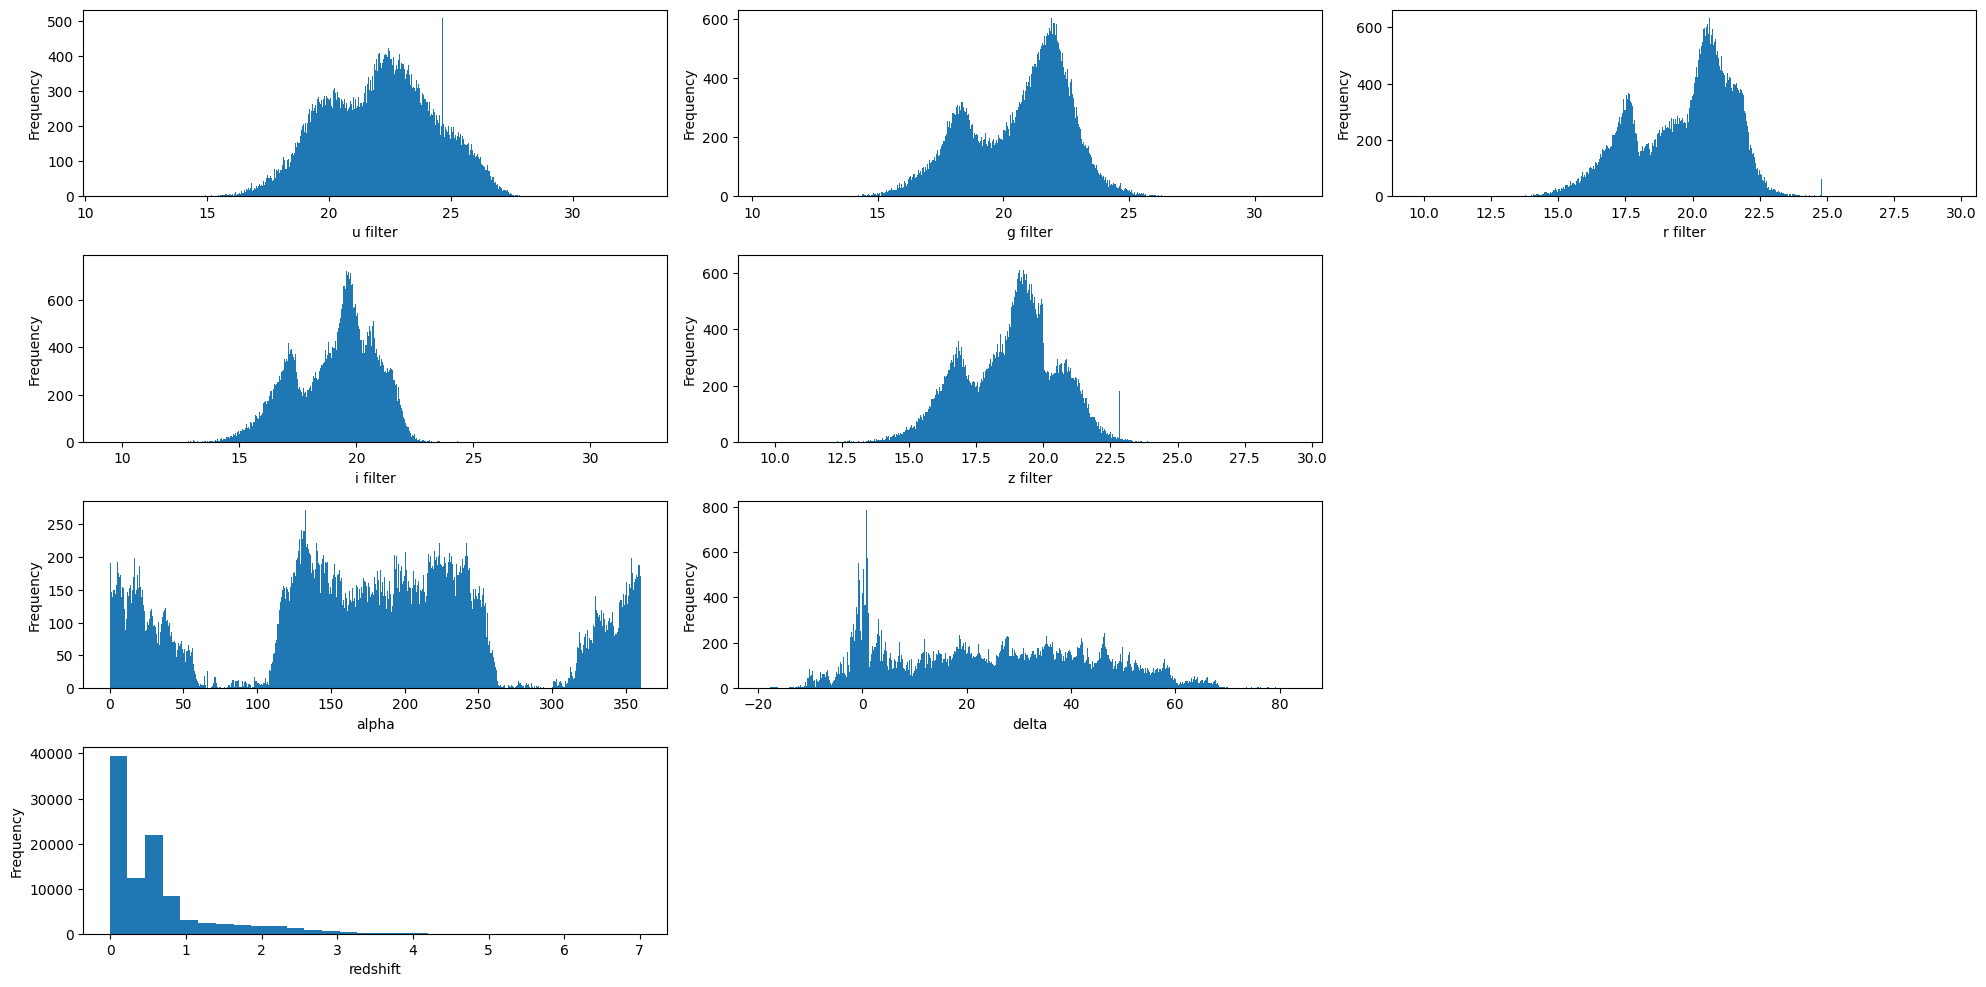

In [8]:
# Create histograms for each of the u, g, r, i, and z filters
plt.figure(figsize=(20, 12))
plt.subplot(5, 3, 1)
plt.hist(star_df['u'], bins = 1000)
plt.xlabel('u filter')
plt.ylabel('Frequency')

plt.subplot(5, 3, 2)
plt.hist(star_df['g'], bins =  1000)
plt.xlabel('g filter')
plt.ylabel('Frequency')

plt.subplot(5, 3, 3)
plt.hist(star_df['r'], bins =  1000)
plt.xlabel('r filter')
plt.ylabel('Frequency')

plt.subplot(5, 3, 4)
plt.hist(star_df['i'], bins =  1000)
plt.xlabel('i filter')
plt.ylabel('Frequency')

plt.subplot(5, 3, 5)
plt.hist(star_df['z'], bins =  1000)
plt.xlabel('z filter')
plt.ylabel('Frequency')

plt.subplot(5, 3, 7)
plt.hist(star_df['alpha'], bins =  1000)
plt.xlabel('alpha')
plt.ylabel('Frequency')

plt.subplot(5, 3, 8)
plt.hist(star_df['delta'], bins =  1000)
plt.xlabel('delta')
plt.ylabel('Frequency')


plt.subplot(5, 3, 10)
plt.hist(star_df['redshift'], bins =  30)
plt.xlabel('redshift')
plt.ylabel('Frequency')





plt.tight_layout()
plt.show()

We can see that the wave lenghts follows somewhat a normal distribution, while fot the alpha and delta coordinate we have a pick of frequency in differente ranges of coordinates, this will not be a particular problem.

While we can see for the redshift values instead, that we have a lot of values that are close to 0, meaning that most of the astronomical objects analysed are quite close to us

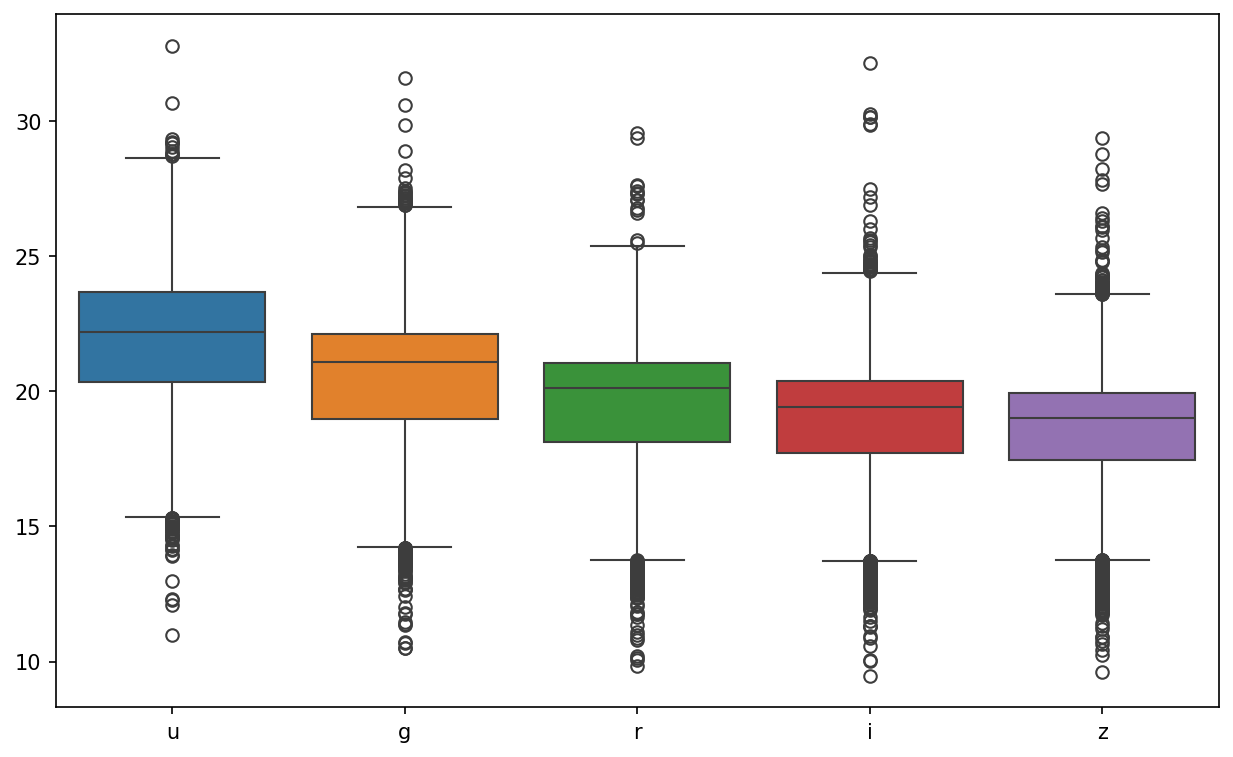

In [9]:
#box plot of the wavelenghts???
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(10,6))
sns.boxplot(star_df[['u','g','r','i','z']], ax=ax)
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

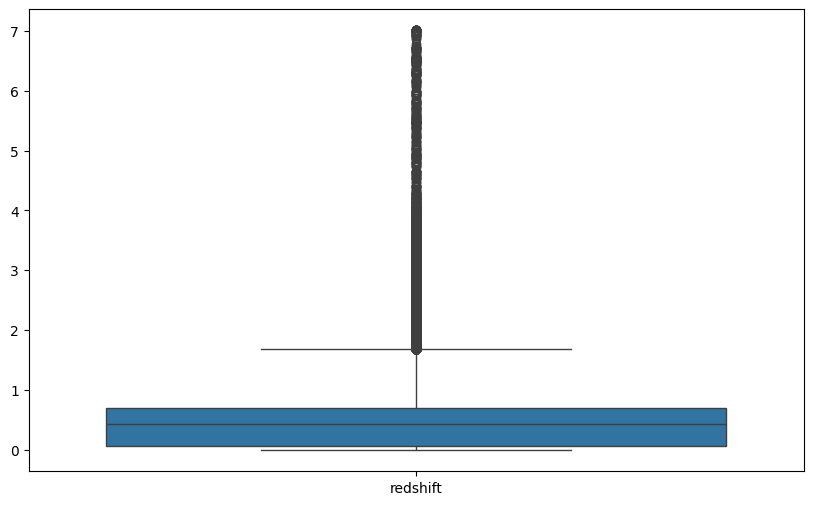

In [10]:
#box plot of the redshift
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(star_df[['redshift']], ax=ax)
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

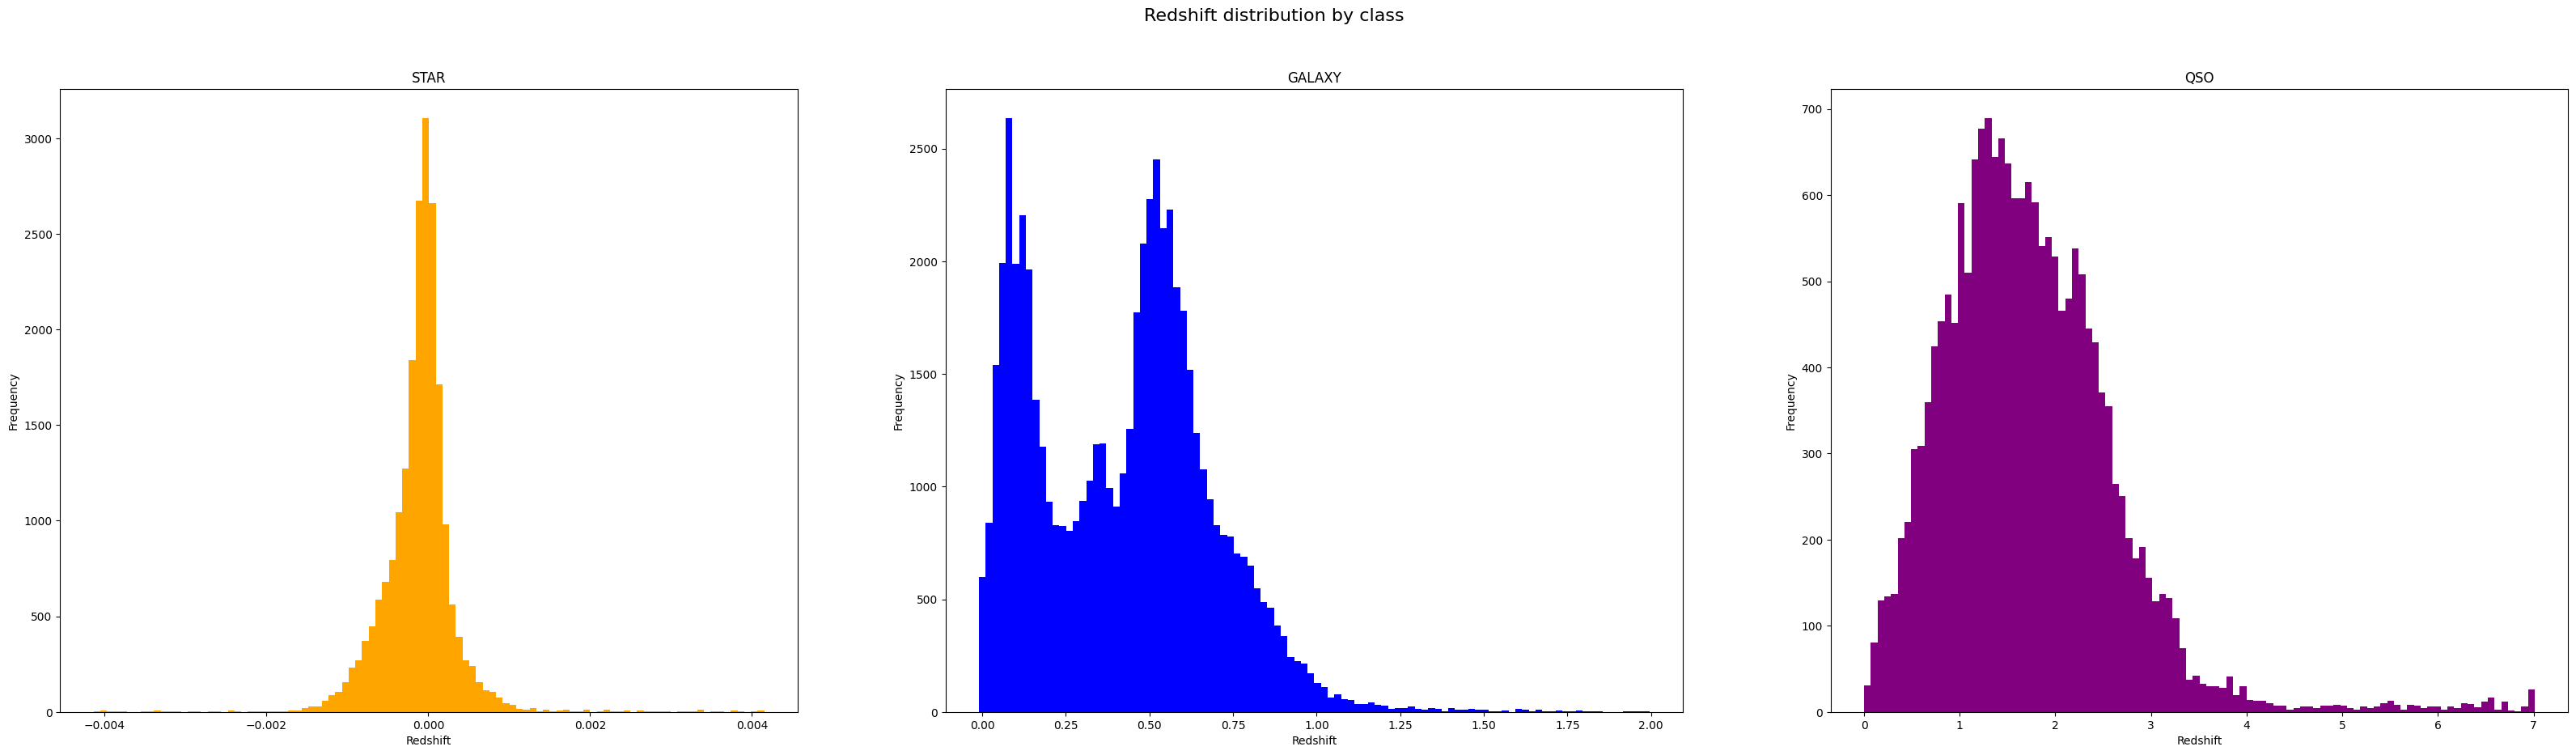

In [50]:
# plot redhisft histogram for each class in different subplots

fig, ax = plt.subplots(1, 3, figsize=(40, 10))
fig.suptitle('Redshift distribution by class', fontsize=16)
star_df[star_df['class'] == 'STAR']['redshift'].plot(kind='hist', bins=100, color='orange', ax=ax[0])
ax[0].set_title('STAR')
ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('Frequency')
star_df[star_df['class'] == 'GALAXY']['redshift'].plot(kind='hist', bins=100, color='blue', ax=ax[1])
ax[1].set_title('GALAXY')
ax[1].set_xlabel('Redshift')
ax[1].set_ylabel('Frequency')
star_df[star_df['class'] == 'QSO']['redshift'].plot(kind='hist', bins=100, color='purple', ax=ax[2])
ax[2].set_title('QSO')
ax[2].set_xlabel('Redshift')
ax[2].set_ylabel('Frequency')
plt.show()




The three classes show significantly different distribution for the redshift value, this again reflect the importance of this particular feature

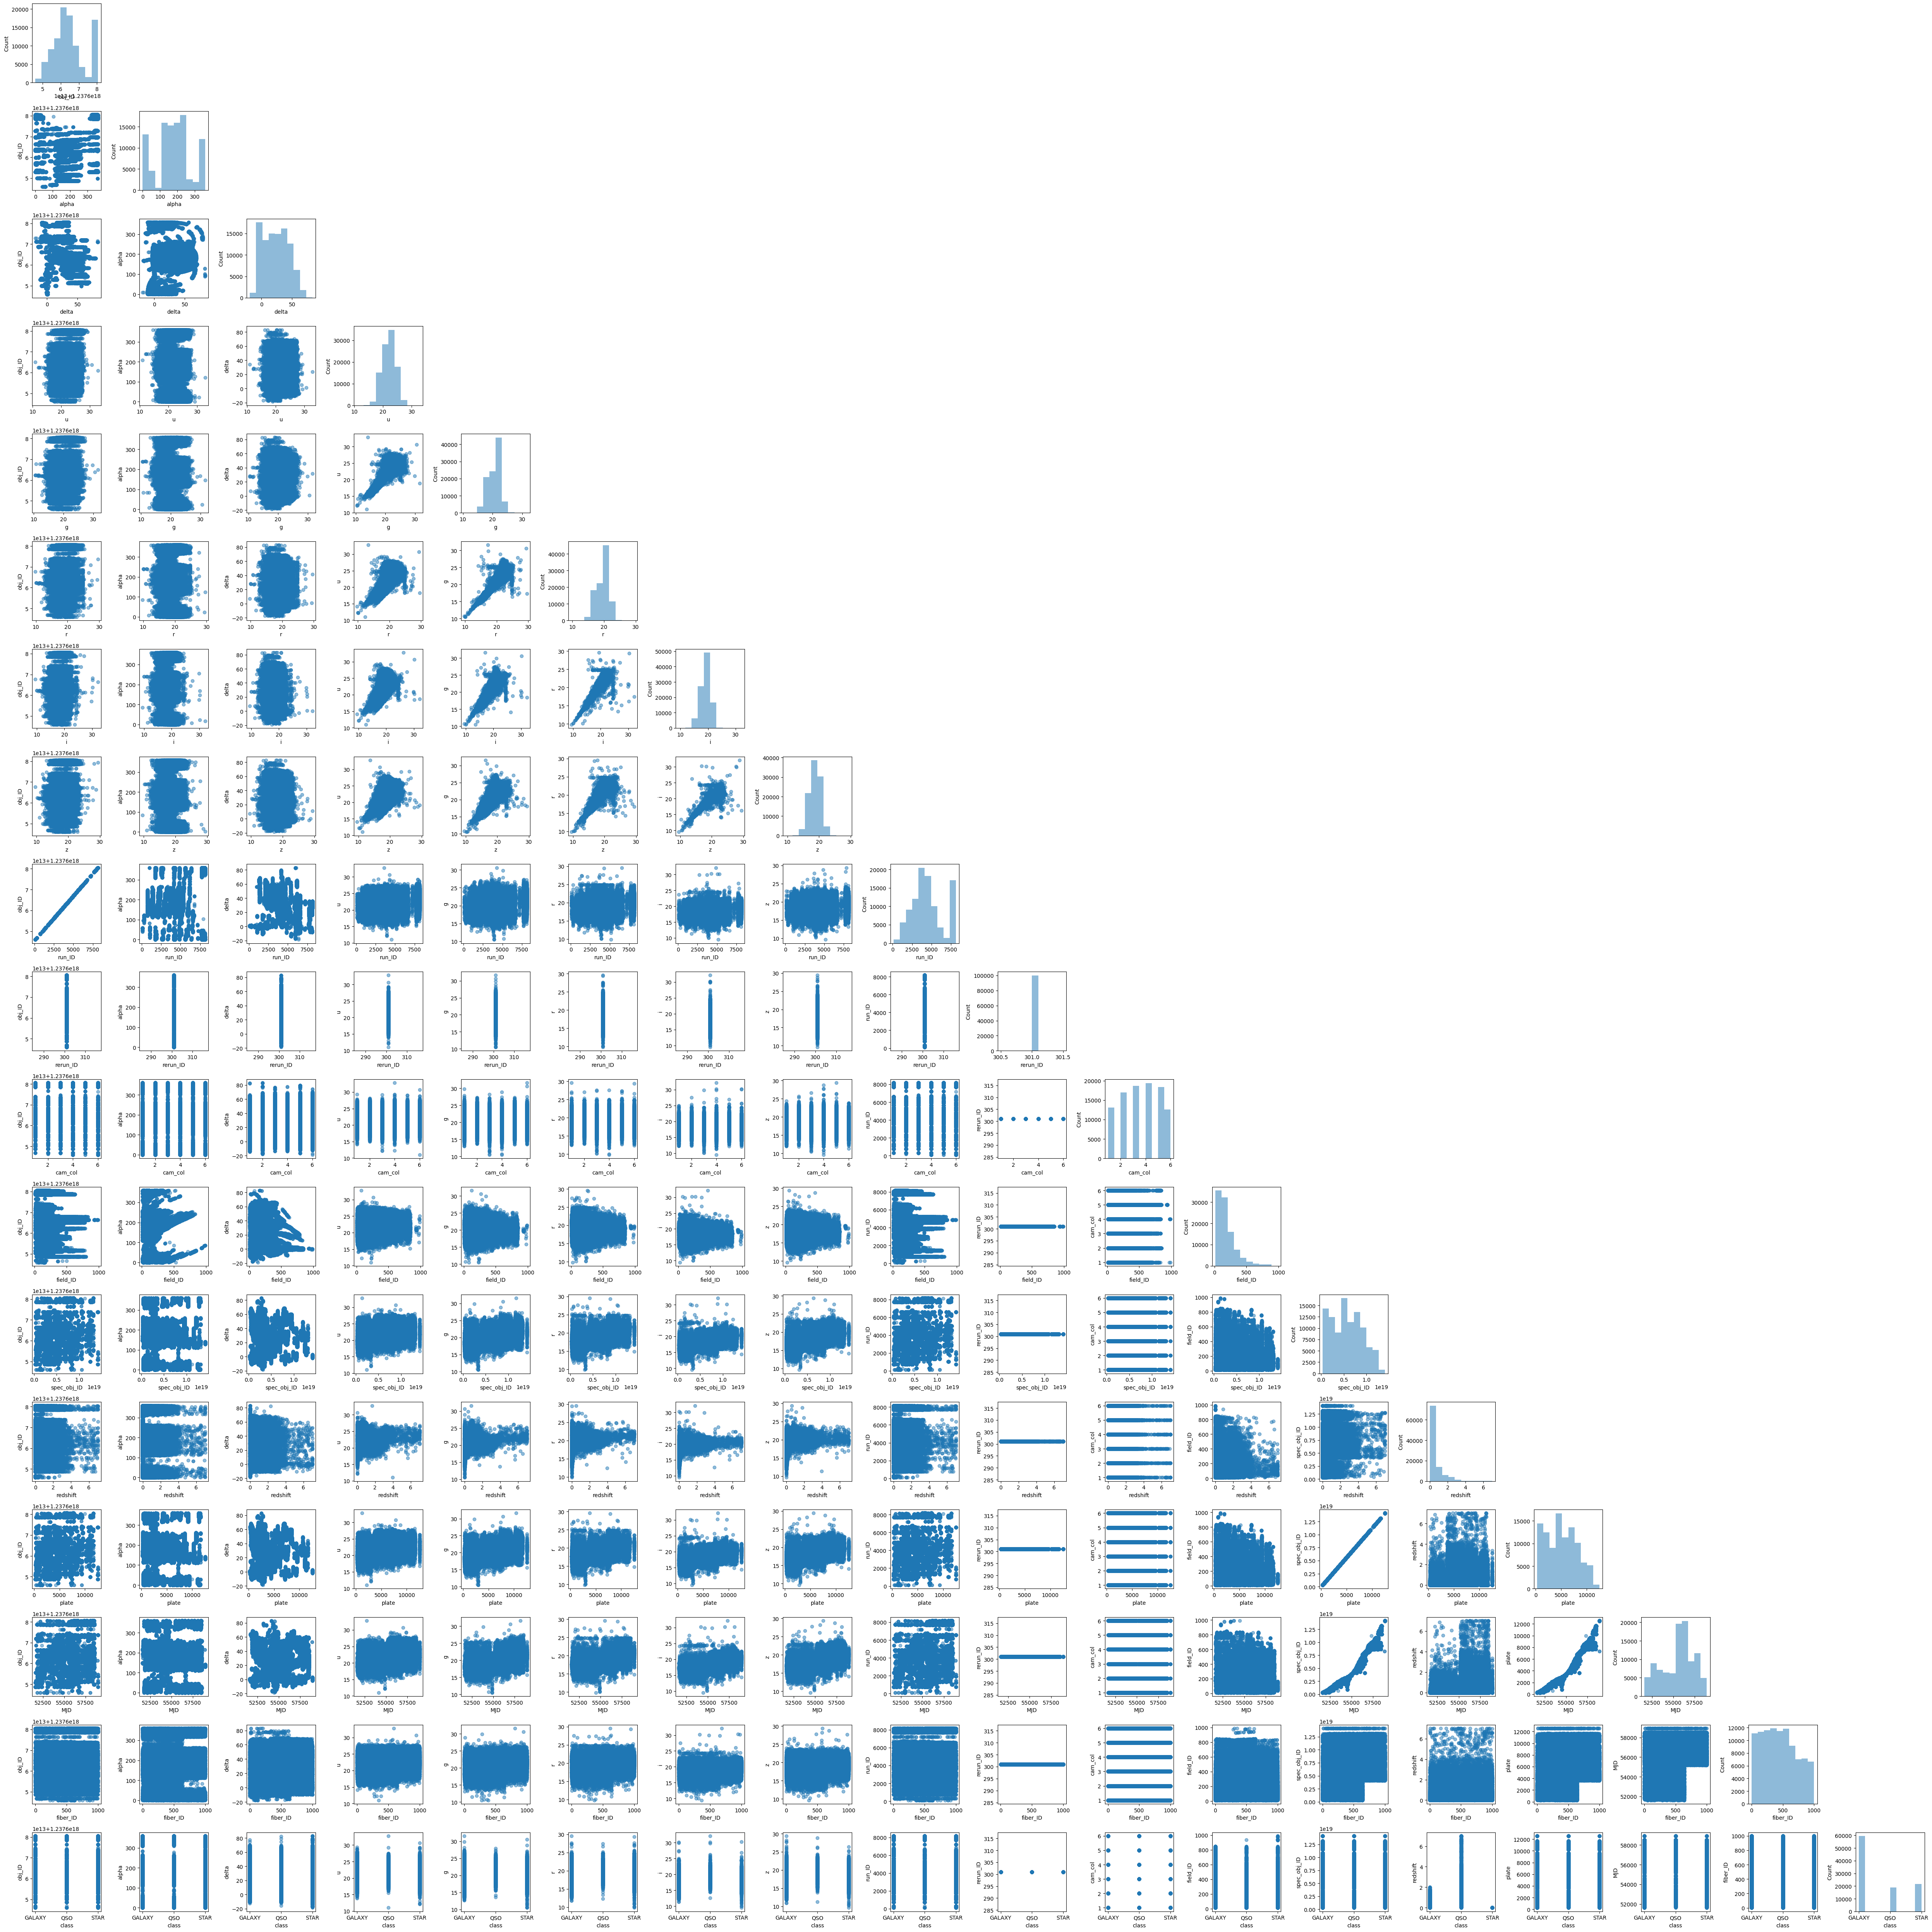

In [25]:
# i want to check if there are some features that follows linearity
from mlxtend.plotting import scatterplotmatrix
scatterplotmatrix(star_df.values, figsize=(50,50),)

plt.tight_layout()
plt.show()

note: We can show that the covariance between a pair of standardized features is, in fact, equal
to their linear correlation coefficient pag 306 book

In [30]:
# correlation matrix


EDA_column_trasformer = ColumnTransformer(transformers=[
    # no need to impute and i don't want to drop first for clarity
    ('one_hot', OneHotEncoder() , ['class']),
    ('KNN_imp', KNNImputer(n_neighbors=5), [col for col in star_df.columns if col != "class"]),
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0,
n_jobs = -1

)

EDA_star = EDA_column_trasformer.fit_transform(star_df)




In [31]:
EDA_star_df = pd.DataFrame(EDA_star, columns = EDA_column_trasformer.get_feature_names_out())
EDA_star_df

class_GALAXY  class_QSO  class_STAR        obj_ID       alpha  \
0               1.0        0.0         0.0  1.237661e+18  135.689107   
1               1.0        0.0         0.0  1.237665e+18  144.826101   
2               1.0        0.0         0.0  1.237661e+18  142.188790   
3               1.0        0.0         0.0  1.237663e+18  338.741038   
4               1.0        0.0         0.0  1.237680e+18  345.282593   
...             ...        ...         ...           ...         ...   
99995           1.0        0.0         0.0  1.237679e+18   39.620709   
99996           1.0        0.0         0.0  1.237679e+18   29.493819   
99997           1.0        0.0         0.0  1.237668e+18  224.587407   
99998           1.0        0.0         0.0  1.237661e+18  212.268621   
99999           1.0        0.0         0.0  1.237661e+18  196.896053   

           delta         u         g         r          i         z  run_ID  \
0      32.494632  23.87882  22.27530  20.39501  19.165730  18.79371  3606.0   
1      31.274185  24.77759  22.83188  22.58444  21.168120  21.61427  4518.0   
2      35.582444  25.26307  22.66389  20.60976  19.243864  18.94827  3606.0   
3      -0.402828  22.13682  23.77656  21.61162  20.504540  19.25010  4192.0   
4      21.183866  19.43718  17.58028  16.49747  15.977110  15.54461  8102.0   
...          ...       ...       ...       ...        ...       ...     ...   
99995  -2.594074  22.16759  22.97586  21.90404  21.305480  20.73569  7778.0   
99996  19.798874  22.69118  22.38628  20.45003  19.757590  19.41526  7913.6   
99997  15.700707  21.16916  19.26997  18.20428  17.690340  17.35221  5314.0   
99998  46.660365  25.35039  21.63757  19.91386  19.072540  18.62482  3650.0   
99999  49.464643  22.62171  21.79745  20.60115  20.009590  19.28075  3650.0   

       rerun_ID  cam_col  field_ID   spec_obj_ID  redshift    plate      MJD  \
0         301.0      2.0      79.0  6.543777e+18  0.634794   5812.0  56354.0   
1         301.0      5.0     119.0  1.176014e+19  0.779136  10445.0  58158.0   
2         301.0      2.0     120.0  5.152200e+18  0.644195   4576.0  55592.0   
3         301.0      3.0     214.0  1.030107e+19  0.932346   9149.0  58039.0   
4         301.0      3.0     137.0  6.891865e+18  0.116123   6121.0  56187.0   
...         ...      ...       ...           ...       ...      ...      ...   
99995     301.0      2.0     581.0  1.055431e+19  0.000000   9374.0  57749.0   
99996     301.0      1.0     289.0  8.586351e+18  0.404895   7626.0  56934.0   
99997     301.0      4.0     308.0  3.112008e+18  0.143366   2764.0  54535.0   
99998     301.0      4.0     131.0  7.601080e+18  0.455040   6751.0  56368.0   
99999     301.0      4.0      60.0  8.343152e+18  0.542944   7410.0  57104.0   

       fiber_ID  
0         171.0  
1         427.0  
2         299.0  
3         775.0  
4         842.0  
...         ...  
99995     438.0  
99996     866.0  
99997      74.0  
99998     470.0  
99999     851.0  

[100000 rows x 20 columns]

----- OTULIER EXPERIMENT ----

In [32]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(EDA_star_df) 

In [33]:
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

#threshold
threshold2 = -1.5                                            
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()

In [34]:
len(outlier_index)

15490

The dataset present a significant amount of outliers values (>15%) so we can't just eliminate them, also because they are probably not erroneus measurment but actual valid values that were collected. Probably their frequency is simply low with respect to the other measurments, thus apperaing as outliers. Collecting more that will probably solve this issue. 

But we must do what we can whit what we have, so we will use models that are robust to outliers such as Random Forest, XGBoost and SVC, and experiment with QuantileTransformer to see if it can help


----- OTULIER EXPERIMENT ----

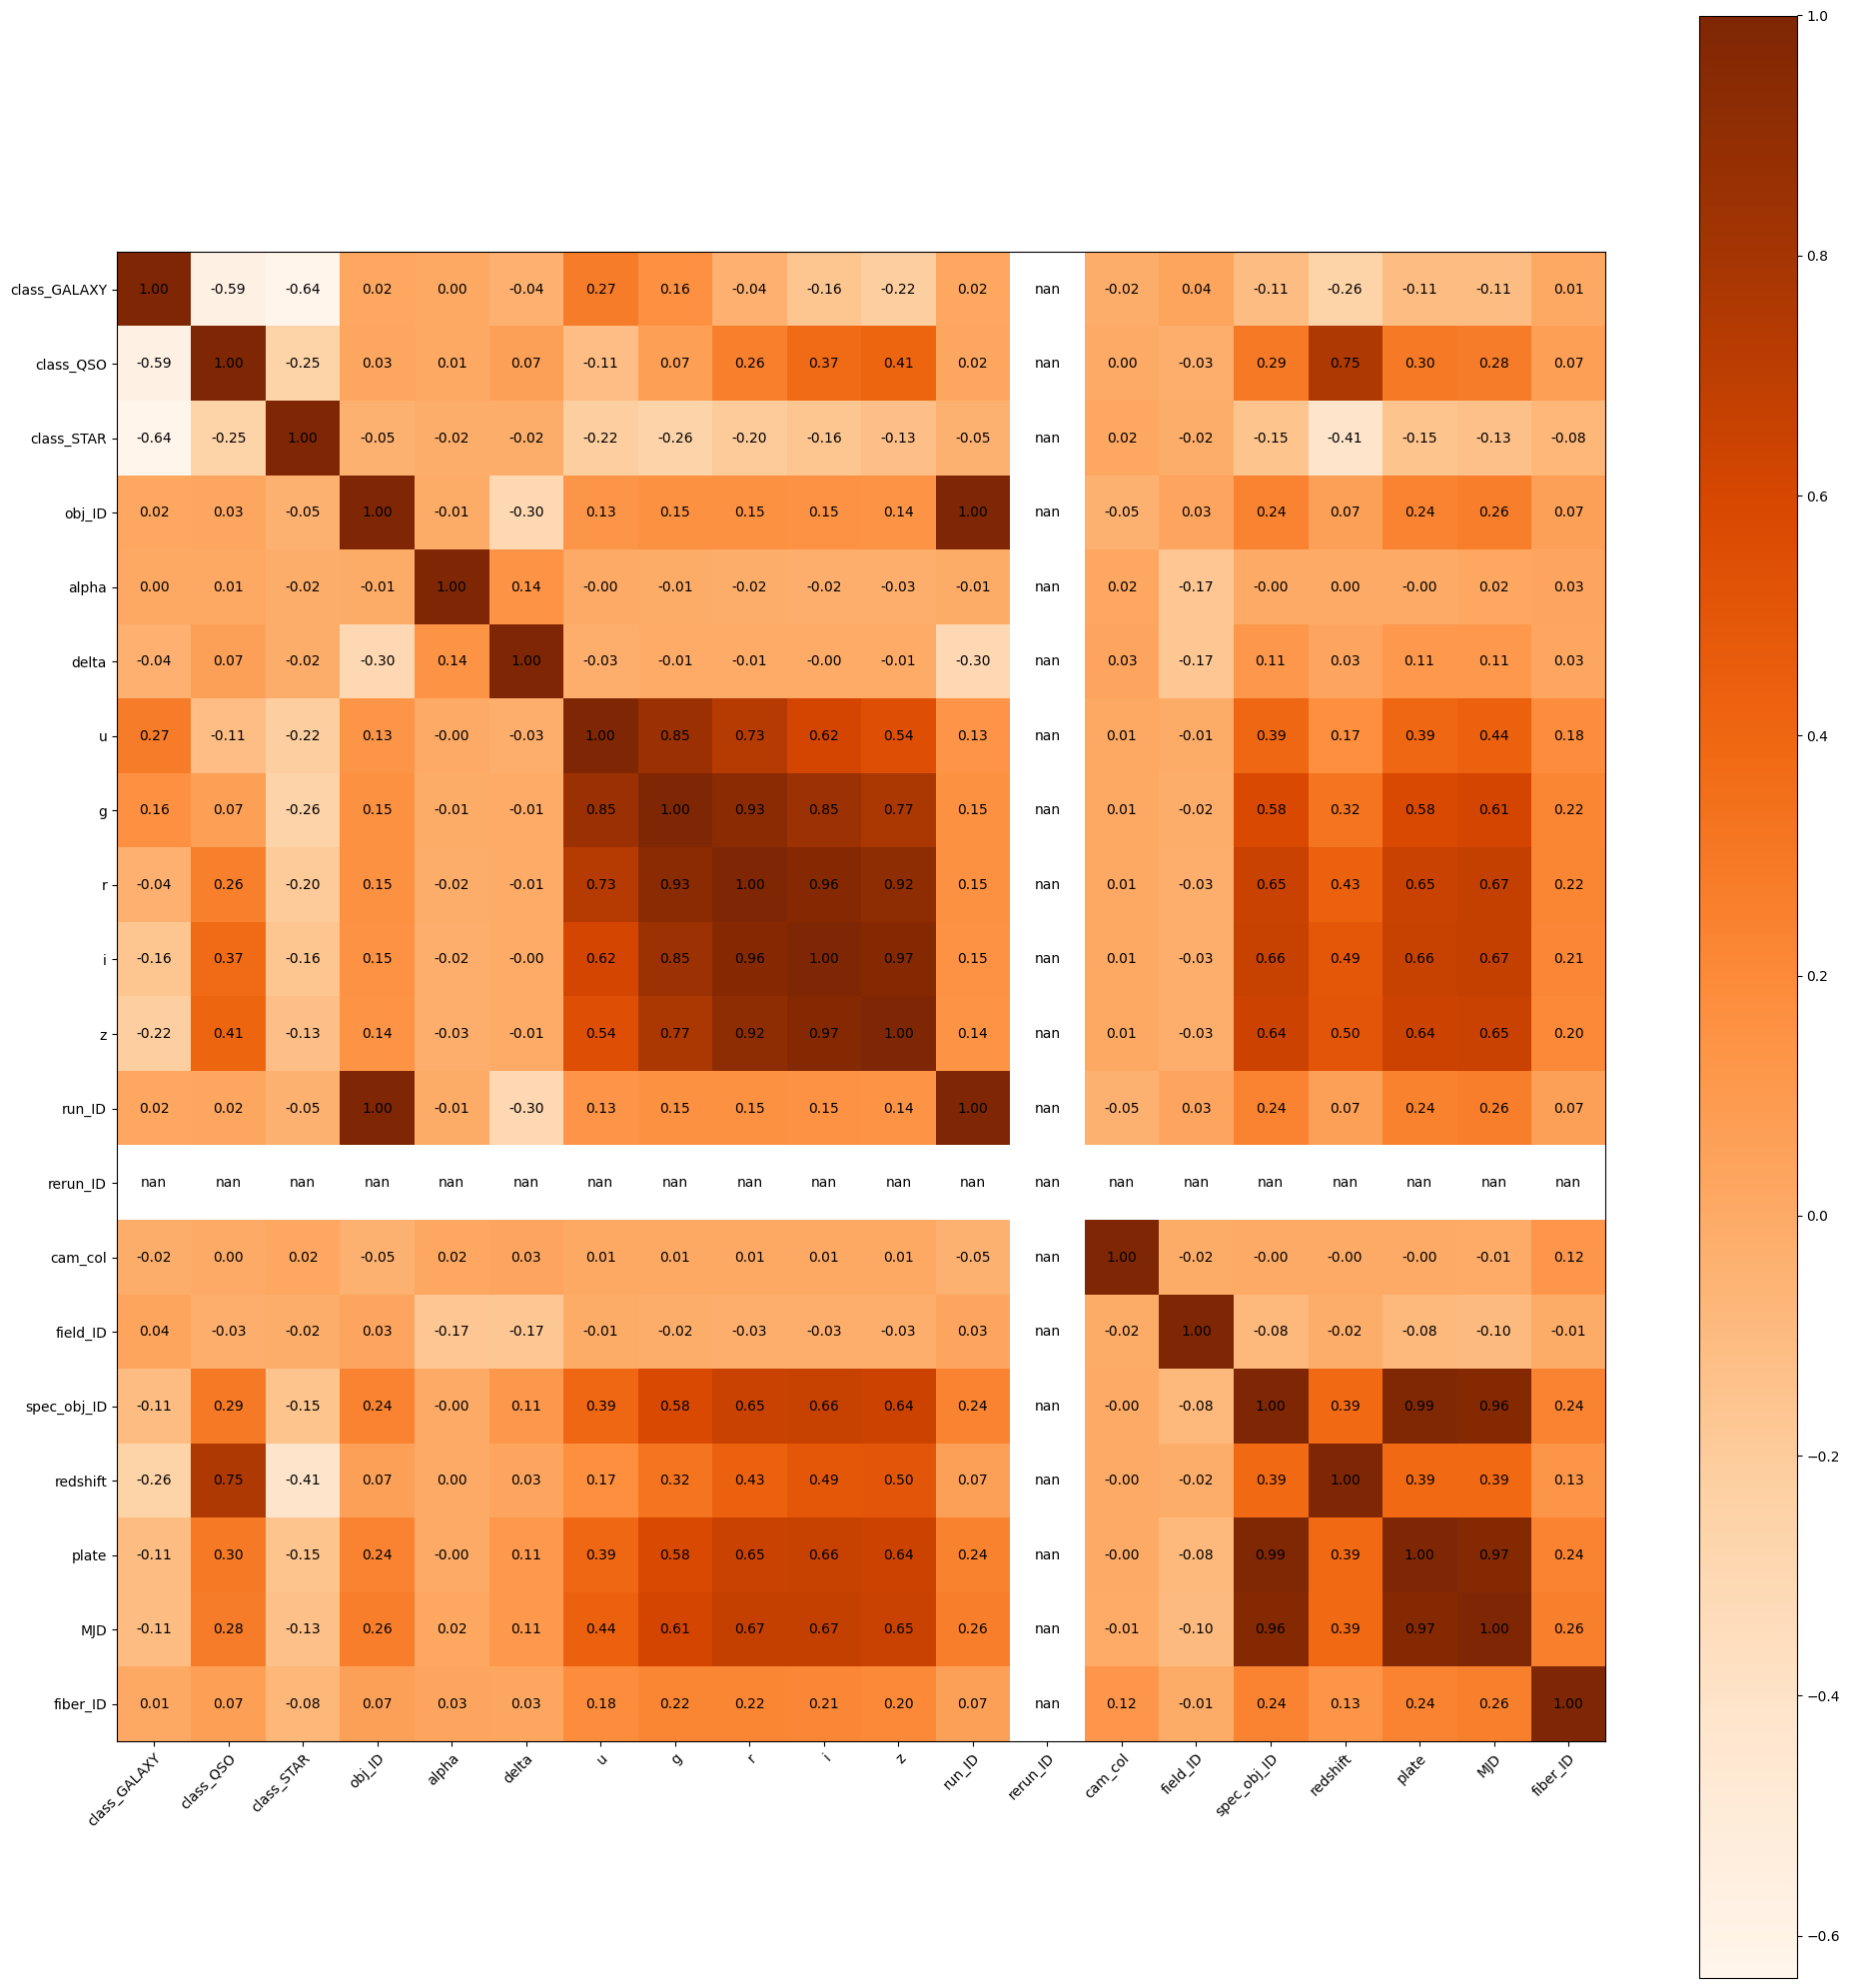

In [35]:
from mlxtend.plotting import heatmap

cm = np.corrcoef(EDA_star_df.values.T)
hm = heatmap(cm, row_names=EDA_star_df.columns, column_names=EDA_star_df.columns,
             figsize = (20,20), cmap='Oranges')
plt.tight_layout()
plt.show()

We can notice that the QSO class has a strong correlation (0.75) with the redshift feature, while the STAR class and the GALAXY class both have a negative correlation score with it. 
We can also see:
 - The alpha and delta coordinates, have close to none correlation with the class labels suggesting that they will be usless during fitting
 - Also the phomtometrics filters value are correlated with the classes
 - Some features are correlated with each other, mostly feature that carry the same type of information
 - The MJD featuere is correlated with QSO, and that could be trublesome, since this feature simply express the time of the observation, indicating that probaby a lot of observations where made in the same time frame, this could create some biases, nervertheless we will keep this feature, since as we will show later, carry some information also for the other classes. We will act as we did not know the meaning of this feature, since we are more intrested in the development of a compelte and satisfactory ML project, than actually classifing space objects. This feature carry a reasonable amount of infomation, so we will keep it. We must keep in mind that in a real application we will disregard this feature along with other features deemed usless using a deep understanding of the specific field knowledge.


In [36]:
# i saw rerun_id as usless so we drop it
EDA_star_df = EDA_star_df.drop(["rerun_ID"], axis=1)


In [37]:
y = EDA_star_df[['class_GALAXY','class_QSO','class_STAR']]
X = EDA_star_df.drop(['class_GALAXY','class_QSO','class_STAR'], axis = 1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.10, random_state=42, stratify=y, shuffle=True )

# Assessing feature importance

We are computing the variance for each feature, high variance features contains the more informations

In [39]:

# scale the data
std_tasformer = StandardScaler()
X_train_std = std_tasformer.fit_transform(X_train)
X_test_std = std_tasformer.transform(X_test)

#X_train_std_df = pd.DataFrame(X_train_std, columns = X_train.columns)

pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_



array([4.03618487e-01, 1.31039723e-01, 9.01023823e-02, 7.00139358e-02,
       6.73267651e-02, 5.50885357e-02, 5.31408997e-02, 4.99530538e-02,
       4.19564019e-02, 2.61764089e-02, 5.83022817e-03, 2.51820136e-03,
       1.60563647e-03, 9.71695461e-04, 4.24788144e-04, 2.32856191e-04])

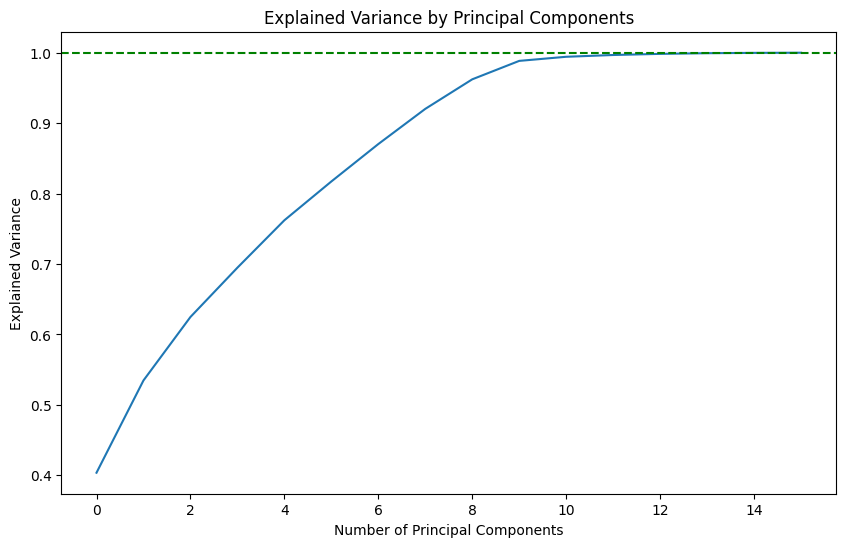

In [40]:
# plot the variance explained by the principal components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
# plot a line at 100% variance
plt.axhline(y=1, color='green', linestyle='--', label='100% Variance')
plt.show()

we will need around 9 of the 17 feature to capture the variance.... pca will probably be good

## Feature importance with random forest

In [41]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train) # no need to scale the data

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

 1) redshift                       0.598295
 2) z                              0.078901
 3) g                              0.062391
 4) i                              0.053959
 5) u                              0.052601
 6) r                              0.032462
 7) plate                          0.031415
 8) spec_obj_ID                    0.028221
 9) MJD                            0.021298
10) delta                          0.008694
11) alpha                          0.007868
12) fiber_ID                       0.006078
13) run_ID                         0.005584
14) field_ID                       0.005519
15) obj_ID                         0.004357
16) cam_col                        0.002358


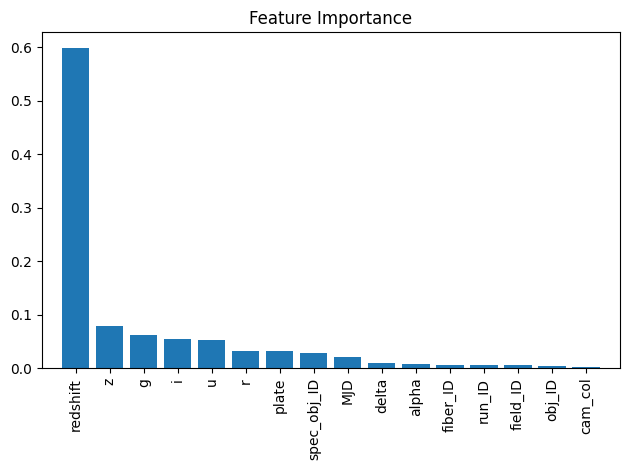

In [42]:
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X_train.columns[indices[f]], importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

we see that redshift is the most important feature while there are several with very little influence, as an experiment we try to remove the redshift as an information and see what happens

In [58]:
# build three different binary classifiers for each class
y_qso_train = y_train['class_QSO']
y_star_train = y_train['class_STAR']
y_galaxy_train = y_train['class_GALAXY']

y_qso_test = y_test['class_QSO']
y_star_test = y_test['class_STAR']
y_galaxy_test = y_test['class_GALAXY']


In [44]:
# random foresest for star
random_forest_star = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
random_forest_star.fit(X_train, y_star_train) # no need to scale the data

# random foresest for qso
random_forest_qso = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
random_forest_qso.fit(X_train, y_qso_train) # no need to scale the data

# random foresest for galaxy
random_forest_galaxy = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
random_forest_galaxy.fit(X_train, y_galaxy_train) # no need to scale the data


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

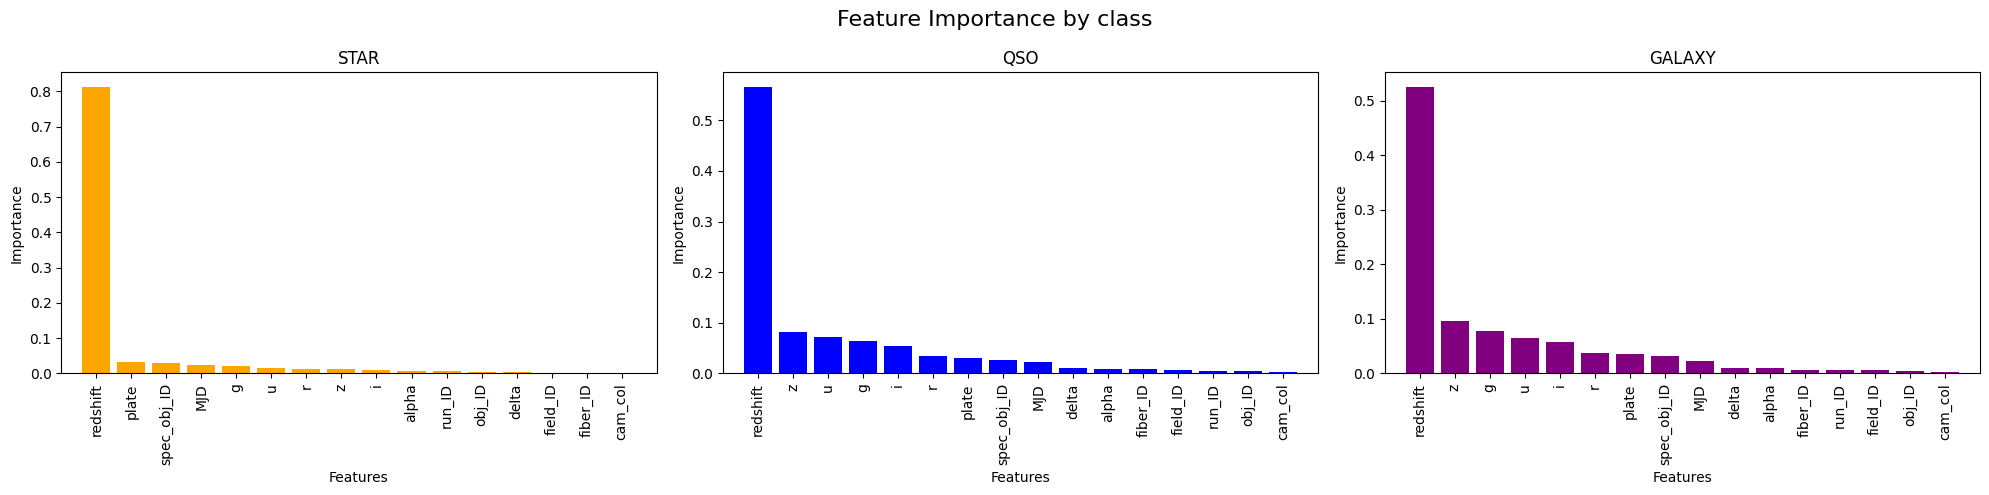

In [49]:
# create 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Feature Importance by class', fontsize=16)

# get the feature importances for each class
importances_star = random_forest_star.feature_importances_
importances_qso = random_forest_qso.feature_importances_
importances_galaxy = random_forest_galaxy.feature_importances_

colors = ['orange', 'blue', 'purple']

# get the indices of the features sorted by importance
for i, (importances, class_name) in enumerate(zip([importances_star, importances_qso, importances_galaxy], ['STAR', 'QSO', 'GALAXY'])):
    indices = np.argsort(importances)[::-1]
    ax[i].set_title(class_name)
    ax[i].bar(range(X_train.shape[1]), importances[indices], align='center', color=colors[i])
    ax[i].set_xticks(range(X_train.shape[1]))
    ax[i].set_xticklabels(X_train.columns[indices], rotation=90)
    ax[i].set_xlim([-1, X_train.shape[1]])
    ax[i].set_xlabel('Features')
    ax[i].set_ylabel('Importance')


plt.tight_layout()
plt.show()

In [60]:
# asses the performance of the models
scores_tree = []
for model, name in zip([random_forest_star, random_forest_qso, random_forest_galaxy], ['class_STAR', 'class_QSO', 'class_GALAXY']):
    y_pred = model.predict(X_test)
    scores_tree.append([name, f1_score(y_test[name], y_pred, average='weighted')])

scores_tree


[['class_STAR', 0.9964967571932615],
 ['class_QSO', 0.9769611286101166],
 ['class_GALAXY', 0.9746579757205626]]

From this rudimental analysis we can expect that we wlll predict more easily star objects rather than QSO or galaxyies, since our classifiers will probably missclassify some particular cases of these two classes. Again, collecting more data would, probably, allow us to threat this issue more precisly.

We also found out hat some of the features carry very little information, and we can expect that some kind of dimensionality reduction as LDA or PCA will be effective, but in order to optimize computational costs, and also thanks to some surface level domain knowledge, we can elimintate some of the features that carry little to no information, keeping instead features like MJD or the astronomical coordinates alpha and delta, that maybe will be of some use

In [61]:
# now we can drop the 5 least important features, such as cam_col, fiber_ID, obj_ID, run_ID
# we keep the alpha and delta because they are the coordinates of the stars, and maybe they are important
X_train = X_train.drop(['cam_col', 'fiber_ID', 'obj_ID', 'run_ID'], axis=1)
X_test = X_test.drop(['cam_col', 'fiber_ID', 'obj_ID', 'run_ID'], axis=1)

# Pipelines

We can use a quantile trasformer that is a standard scalar that is robust to outliers

In [62]:
# basic pipelline 
model_pipeline = IMBPipeline([
    ('scaler', QuantileTransformer()),
    ('sampler', SMOTE(sampling_strategy='auto')),  # Adjust strategy as needed
    ('dim_reduction', PCA(n_components=0.95 )),  # Adjust components based on data
    ('clf', DecisionTreeClassifier(random_state=0))
],verbose=False
)


In [63]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
model_pipeline.fit(X_train_array,y_train_array)
y_pred = model_pipeline.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9173934023971048

In [64]:
# configurations

sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 0.2, 0.9, 0.7, 'auto'],
        'sampler__k_neighbors':[5,7,10,15,20]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority']
    },
   {
        'sampler':[RandomUnderSampler()],
        'sampler__sampling_strategy':['majority']
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    }, 
    {
         'dim_reduction': [PCA()],
         'dim_reduction__n_components': [0.65, 0.7, 0.8, 0.9, 0.95],
    },
     {
         'dim_reduction': [LDA()],
         'dim_reduction__solver': ['svd', 'lsqr', 'eigen'],
         'dim_reduction__shrinkage': [None, 'auto'],
         'dim_reduction__n_components': [None, 1, 2]
     }
]



xgb_config = [{
        'clf' : [xgb.XGBClassifier( n_jobs = -1, random_state=42)], # provide validatio for early stopping
       'clf__n_estimators' :[100, 200, 350],
        #'clf__booster' : ['gbtree', 'dart'],  # no gblinear
        'clf__learning_rate' : loguniform(0.001,0.1),

        'clf__max_depth' : [3, 5, 7],
        #'clf__reg_alpha' : uniform(0,0.5),
        #'clf__reg_lambda' : uniform(0,0.5),

        #'clf__min_child_weight' : loguniform(1, 50), # smaller values make the algorithm more conservative
    #   'clf__gamma' : uniform(0,0.5),]
    }]

rf_config = [{
        'clf' : [RandomForestClassifier( random_state=42,n_jobs=-1, bootstrap=True)], # provide validatio for early stopping
        'clf__n_estimators' : [100,200,300,500,800,1000],
        'clf__max_samples' : uniform(0.1,1), #try for overfitting
        'clf__max_features': ['auto', 'sqrt'],
        'clf__criterion' : [ 'gini', 'entropy', 'log_loss'],
        'clf__max_depth' : [10, 20, 50, 60, 70, 80, 90, 100],
        'clf__min_samples_leaf': [1, 2, 4],   
    }]

svc_config = [ {
        
        'clf': [SVC()],
        'clf__kernel': ['linear', 'rbf'],
        'clf__C': loguniform(0.001, 100),
        'clf__gamma': loguniform(0.0001, 1),       
    }]


  

svc_all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,svc_config)]

xgb_all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,xgb_config)]

rf_all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,rf_config)]

f'Number of all possible configurations: {len(rf_all_configs) + len(svc_all_configs) + len(xgb_all_configs)}'

'Number of all possible configurations: 36'

In [65]:
rs_svc = RandomizedSearchCV(model_pipeline,
    param_distributions=svc_all_configs,
    n_iter=len(svc_all_configs)*2,
    n_jobs=-1,
    cv = 3,
    scoring='f1_weighted',
    verbose=3,
)

rs_xgb = RandomizedSearchCV(model_pipeline,
    param_distributions=xgb_all_configs,
    n_iter=len(xgb_all_configs)*4,
    n_jobs=-1,
    cv = 3,
    scoring='f1_weighted',
    verbose=3,
)
rs_rf = RandomizedSearchCV(model_pipeline,
    param_distributions=rf_all_configs,
    n_iter=len(rf_all_configs)*5,
    n_jobs=-1,
    cv = 3,
    scoring='f1_weighted',
    verbose=3,
)



In [66]:
# need to convert back the y array into a 1D array to use svc in a multiclass problem
y_train_one_dim = np.argmax(y_train_array, axis=1)
y_test_one_dim = np.argmax(np.array(y_test), axis=1)

In [35]:
rf_scores = cross_validate(rs_rf, X_train_array, y_train_one_dim, scoring='f1_weighted', cv = 5, return_estimator=True, verbose=3) 

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ......................................., score=0.974 total time= 4.5min
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ......................................., score=0.975 total time= 5.0min
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ......................................., score=0.977 total time= 4.4min
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ......................................., score=0.975 total time= 4.1min
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ......................................., score=0.978 total time= 6.2min


In [67]:
xgb_scores = cross_validate(rs_xgb, X_train_array, y_train_one_dim, scoring='f1_weighted', cv = 5, return_estimator=True, verbose=3)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ......................................., score=0.974 total time= 1.1min
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ......................................., score=0.972 total time=  59.6s
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ......................................., score=0.977 total time=  57.4s
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ......................................., score=0.975 total time= 1.1min
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ......................................., score=0.976 total time=  50.8s


In [37]:
svc_scores = cross_validate(rs_svc, X_train_array, y_train_one_dim, scoring='f1_weighted', cv = 5, return_estimator=True, verbose=3)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ......................................., score=0.964 total time=54.6min
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ......................................., score=0.964 total time=22.1min
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ......................................., score=0.958 total time=13.7min
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ......................................., score=0.958 total time=15.5min
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ......................................., score=0.957 total time= 8.5min


In [ ]:
with open('rf_scores.txt', 'w') as f:
    f.write(str(rf_scores))

with open('xgb_scores.txt', 'w') as f:
    f.write(str(xgb_scores))

with open('svc_scores.txt', 'w') as f:
    f.write(str(svc_scores))

In [68]:
for index, estimator in enumerate(xgb_scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['clf'],estimator.best_estimator_.get_params()['clf'].get_params())
    print(xgb_scores['test_score'][index])
    print('-'*50)

None
None
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02254903520067042,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...) {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 

In [40]:
for index, estimator in enumerate(svc_scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['clf'],estimator.best_estimator_.get_params()['clf'].get_params())
    print(svc_scores['test_score'][index])
    print('-'*50)

RandomOverSampler(sampling_strategy='minority')
None
SVC(C=88.57612978156084, gamma=0.3194288351184975) {'C': 88.57612978156084, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.3194288351184975, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
0.9642024100252733
--------------------------------------------------
RandomOverSampler(sampling_strategy='minority')
None
SVC(C=7.159971083589795, gamma=0.5965507351449018) {'C': 7.159971083589795, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.5965507351449018, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
0.9635809166237636
--------------------------------------------------
None
None
SVC(C=75.8772152593048, gamma=0.

In [41]:
for index, estimator in enumerate(rf_scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['clf'],estimator.best_estimator_.get_params()['clf'].get_params())
    print(rf_scores['test_score'][index])
    print('-'*50)

None
None
RandomForestClassifier(max_depth=70, max_samples=0.9072890126410986,
                       min_samples_leaf=4, n_estimators=800, n_jobs=-1,
                       random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 70, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.9072890126410986, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 800, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.9744014022428374
--------------------------------------------------
None
None
RandomForestClassifier(criterion='entropy', max_depth=20,
                       max_samples=0.9765158958738804, n_jobs=-1,
                       random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes'

In [43]:
for estimator in rf_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train_array, y_train_one_dim)
    pred_train = estimator.best_estimator_.predict(X_train_array)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train_one_dim, pred_train,average='weighted')
    f1_test = f1_score(y_test_one_dim, pred_test, average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')



F1 on training set:0.9848830361762071, F1 on test set:0.9742517309643148
F1 on training set:0.9980634382805285, F1 on test set:0.974659418729421
F1 on training set:0.9958699890796134, F1 on test set:0.974446292869199
F1 on training set:1.0, F1 on test set:0.9733353650600182
F1 on training set:0.988991413230299, F1 on test set:0.9737329757725258


In [70]:
for estimator in xgb_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train_array, y_train_one_dim)
    pred_train = estimator.best_estimator_.predict(X_train_array)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train_one_dim, pred_train,average='weighted')
    f1_test = f1_score(y_test_one_dim, pred_test, average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.981490662628426, F1 on test set:0.9739581382262062
F1 on training set:0.975784210322523, F1 on test set:0.9716932905423924
F1 on training set:0.9832320507881015, F1 on test set:0.9743692210178382
F1 on training set:0.9808450869381363, F1 on test set:0.9740734126136033
F1 on training set:0.9780167860043293, F1 on test set:0.9733542157140193


In [45]:
for estimator in svc_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train_array, y_train_one_dim)
    pred_train = estimator.best_estimator_.predict(X_train_array)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train_one_dim, pred_train,average='weighted')
    f1_test = f1_score(y_test_one_dim, pred_test, average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.967942459595704, F1 on test set:0.9619851576379851
F1 on training set:0.9670653857468215, F1 on test set:0.9622257271770568
F1 on training set:0.9573971526692568, F1 on test set:0.9547372148653147
F1 on training set:0.9576939775922106, F1 on test set:0.954115135219756
F1 on training set:0.9567789080003251, F1 on test set:0.9532224230900443


RF models are the ones with the highest perfomance of the three, while they present a slight overfitting, xgb classifiers are very close in perfomance to the RF but overfit a bit less. SVC are the classifiers that present the least overfitting but also have a noticebly overall worst perfomance. It would be intresting to explore furthere also the optimal configuation for the SVC but it will be too computational expensive so we will bring forward only the random forest and the xgb best models, hopefully ensambling them and making a soft max voting classifier, to improve further the performance

## Visualize and study resoults

In [ ]:
xgb_clf = xgb_scores['estimator'][0].best_estimator_
svc_clf = svc_scores['estimator'][0].best_estimator_
rf_clf = rf_scores['estimator'][0].best_estimator_


In [60]:
import joblib
joblib.dump(xgb_clf, 'xgb_clf.sav')
joblib.dump(svc_clf, 'svc_clf.sav')
joblib.dump(rf_clf, 'rf_clf.sav')

['rf_cls.sav']

In [72]:
import joblib
xgb_clf = joblib.load('xgb_cls.sav')
svc_clf = joblib.load('svc_cls.sav')
rf_clf = joblib.load('rf_cls.sav')

In [73]:
xgb_clf.get_params()

{'memory': None,
 'steps': [('scaler', QuantileTransformer()),
  ('sampler', None),
  ('dim_reduction', None),
  ('clf',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.07968232288208799,
                 max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=350, n_jobs=-1,
                 num_parallel_tree=None, objective='multi:softprob', ...))],
 'verbose': False,
 'scaler': QuantileTransformer(),
 'sampler': No

In [78]:
rf_clf.get_params()

{'memory': None,
 'steps': [('scaler', QuantileTransformer()),
  ('sampler', None),
  ('dim_reduction', None),
  ('clf',
   RandomForestClassifier(max_depth=70, max_samples=0.9072890126410986,
                          min_samples_leaf=4, n_estimators=800, n_jobs=-1,
                          random_state=42))],
 'verbose': False,
 'scaler': QuantileTransformer(),
 'sampler': None,
 'dim_reduction': None,
 'clf': RandomForestClassifier(max_depth=70, max_samples=0.9072890126410986,
                        min_samples_leaf=4, n_estimators=800, n_jobs=-1,
                        random_state=42),
 'scaler__copy': True,
 'scaler__ignore_implicit_zeros': False,
 'scaler__n_quantiles': 1000,
 'scaler__output_distribution': 'uniform',
 'scaler__random_state': None,
 'scaler__subsample': 10000,
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': None,
 'clf__criterion': 'gini',
 'clf__max_depth': 70,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_nodes': None,
 'clf__max_samp

In [74]:
# pipleins for optimal models
xgb_best_model_pipeline = IMBPipeline([
    ('scaler', QuantileTransformer()),
    ('sampler', None),  # Adjust strategy as needed
    ('dim_reduction', None),  # Adjust components based on data
    ('clf', xgb.XGBClassifier( n_jobs = -1, random_state=42))
],verbose=False
)

rf_best_model_pipeline = IMBPipeline([
    ('scaler', QuantileTransformer()),
    ('sampler', None),  # Adjust strategy as needed
    ('dim_reduction', None),  # Adjust components based on data
    ('clf', RandomForestClassifier( random_state=42,n_jobs=-1, bootstrap=True))
],verbose=False
)

In [110]:
# optimal configurations 

xgb_optimal_parameters = [ {
        
        'clf__n_estimators' :[100, 200,350,400,500],
        'clf__booster' : ['gbtree', 'dart'],  # no gblinear
        'clf__learning_rate' : loguniform(0.001,0.1),

        'clf__max_depth' : [3, 5, 7,9],
        'clf__reg_alpha' : uniform(0,0.5),
        'clf__reg_lambda' : uniform(0,0.5),

        'clf__min_child_weight' : loguniform(1, 50), # smaller values make the algorithm more conservative
        'clf__gamma' : uniform(0,0.5),
    
         
    }]

rf_optimal_parameters = [ {
        
    'clf__n_estimators': [100,200,300,500,800,1000],
    'clf__max_samples': uniform(0.1,1), #try for overfitting
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__criterion' : [ 'gini', 'entropy', 'log_loss'],
    'clf__max_depth' : [10, 20, 50, 60, 70, 80, 90, 100],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__min_samples_split': [2, 5, 10],
    'clf__class_weight':['balanced', 'balanced_subsample', None] , 
    }]

In [111]:
rs_xgb_optimal = RandomizedSearchCV(
    estimator = xgb_best_model_pipeline,
    param_distributions= xgb_optimal_parameters ,
    n_iter=30,
    n_jobs=-1,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    scoring='f1_weighted',
    verbose=3,
)

In [ ]:
rs_xgb_optimal.fit(X_train_array, y_train_one_dim)
 

In [ ]:
f1_score(y_test_one_dim, rs_xgb_optimal.best_estimator_.predict(X_test), average='weighted')

0.9745893512445793

In [73]:
f1_score(y_test_one_dim, xgb_clf.predict(X_test), average='weighted')


0.9739830011267797

random forest

In [83]:
rs_rf_optimal = RandomizedSearchCV(
    estimator = rf_best_model_pipeline,
    param_distributions= rf_optimal_parameters ,
    n_iter=30,
    n_jobs=-1,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    scoring='f1_weighted',
    verbose=3,
)

In [84]:
rs_rf_optimal.fit(X_train_array, y_train_array)
f1_score(y_test_one_dim, rs_rf_optimal.best_estimator_.predict(X_test), average='weighted')

Fitting 15 folds for each of 30 candidates, totalling 450 fits


0.975177241051574

In [85]:
import joblib
joblib.dump(rs_xgb_optimal, 'rs_xgb_optimal.sav')
joblib.dump(rs_rf_optimal, 'rs_rf_optimal.sav')

['rs_rf_optimal.sav']

In [116]:
import joblib
rs_xgb_optimal = joblib.load('rs_xgb_optimal.sav')
rs_rf_optimal = joblib.load('rs_rf_optimal.sav')

In [118]:
rs_xgb_optimal.best_params_

{'clf__booster': 'dart',
 'clf__gamma': 0.004640430734934309,
 'clf__learning_rate': 0.02853415748864355,
 'clf__max_depth': 7,
 'clf__min_child_weight': 16.46890297753569,
 'clf__n_estimators': 500,
 'clf__reg_alpha': 0.2055407080725749,
 'clf__reg_lambda': 0.26218109692295155,
 'dim_reduction': None,
 'sampler': None,
 'scaler': QuantileTransformer()}

In [119]:
rs_rf_optimal.best_params_

{'clf__class_weight': 'balanced',
 'clf__criterion': 'log_loss',
 'clf__max_depth': 80,
 'clf__max_features': None,
 'clf__max_samples': 0.9451274419599356,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 500}

In [76]:
xgb_clf_optimal = rs_xgb_optimal.best_estimator_
rf_clf_optimal = rs_rf_optimal.best_estimator_

In [78]:
# asses overffing of the two models

f1_train_xgb = f1_score(y_train_one_dim, xgb_clf_optimal.predict(X_train_array), average='weighted')
f1_test_xgb = f1_score(y_test_one_dim, xgb_clf_optimal.predict(X_test), average='weighted')
print(f'XGB :F1 on training set:{f1_train_xgb}, F1 on test set:{f1_test_xgb}')

f1_train_rf = f1_score(y_train_one_dim, rf_clf_optimal.predict(X_train_array), average='weighted')
f1_test_rf = f1_score(y_test_one_dim, rf_clf_optimal.predict(X_test), average='weighted')
print(f'RF: F1 on training set:{f1_train_rf}, F1 on test set:{f1_test_rf}')


XGB :F1 on training set:0.9883765377917471, F1 on test set:0.9745893512445793
RF: F1 on training set:1.0, F1 on test set:0.975177241051574


We can see that optimizing the RF model increased the orverfit, but the overall perfomance on unseen data is slightly improved. WHile for the XGB classifier we also increased slightly the overfitting, but also in this case we improved the perfomance on unseen data so we are satisfied with the overall resoult. 

### Confusion matrixed for the optimized models and SVC

Now we will study the missclassification and see if our predictions were accurate, and if the models have a satisafctory perfomance

In [81]:
# confusion matrix
# note: The confusion matrix takes a vector of labels (not the one-hot encoding), run the argmax method on the one-hot encoding to convert it to a vector of labels
y_pred_xgb = xgb_clf_optimal.predict(X_test)
cf_xgb = confusion_matrix(y_test_one_dim, y_pred_xgb)

y_pred_rf = rf_clf_optimal.predict(X_test)
cf_rf = confusion_matrix(y_test_one_dim, y_pred_rf)

y_pred_svc = svc_clf.predict(X_test)
cf_svc = confusion_matrix(y_test_one_dim, y_pred_svc)


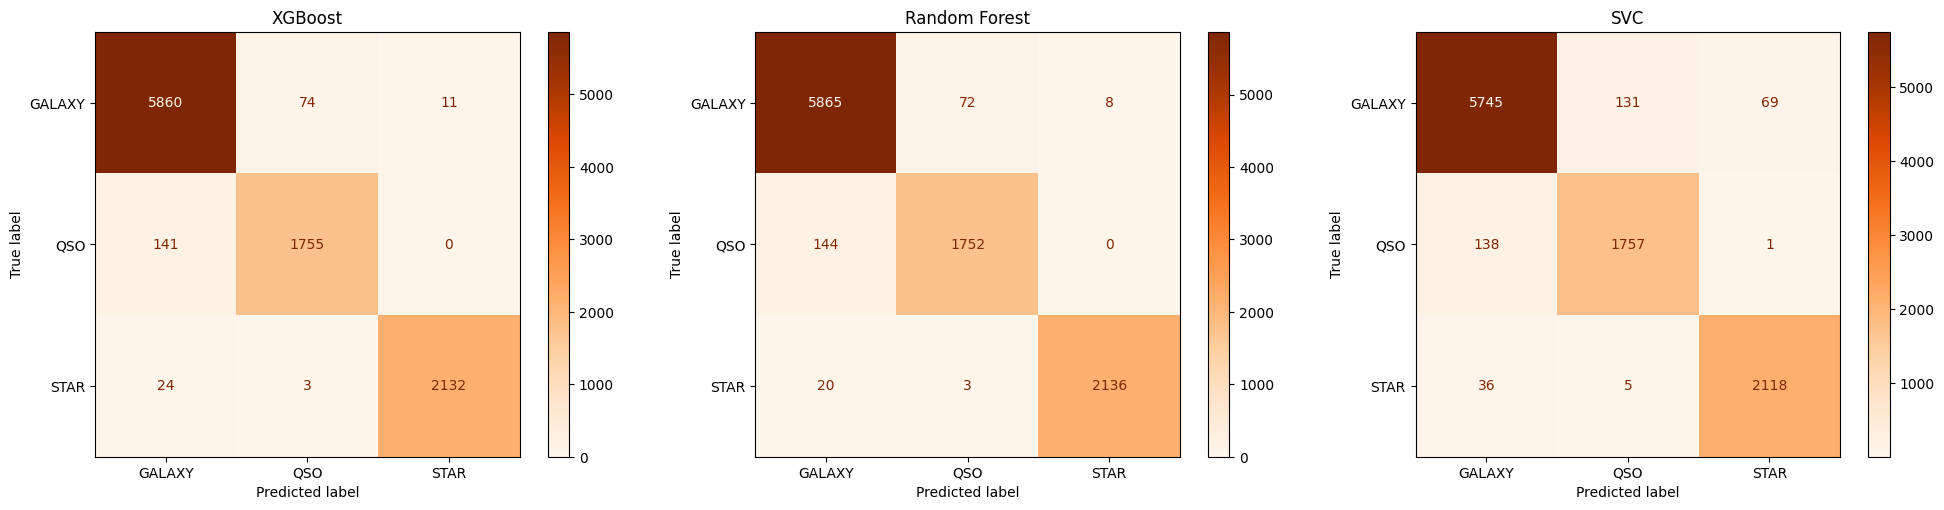

In [82]:
# plot the 3 confusion matrix next to each other
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ConfusionMatrixDisplay(cf_xgb, display_labels=['GALAXY','QSO','STAR']).plot(cmap='Oranges', ax=ax[0])
ax[0].set_title('XGBoost')
ConfusionMatrixDisplay(cf_rf, display_labels=['GALAXY','QSO','STAR']).plot(cmap='Oranges', ax=ax[1])
ax[1].set_title('Random Forest')
ConfusionMatrixDisplay(cf_svc, display_labels=['GALAXY','QSO','STAR']).plot(cmap='Oranges', ax=ax[2])
ax[2].set_title('SVC')
plt.tight_layout()
plt.show()

We can notice that STAR in all models are mostly classified correctly. All the models do present some issues classifing QSO ans GALAXY, tending to missclassify QSO as GALAXY, and less frequently GALAXY as QSO. Unoftunalty from the confusion matrix of the unoptimized SVC we can see that it does not help distinguish those two classes, it perform even worse missclassifing more GALAXY as QSO, so we are forced to leave it behind and try to build an esnamble with only the RF and the XGB classifiers

# --------------Majority voting ensamble--------------

Esnamble learning always perfom better than individual classifiers as long as each classifier is better than random guessing

In [92]:
clf_voting = VotingClassifier(estimators=[('xgb', xgb_clf_optimal), ('rf', rf_clf_optimal)], voting='soft', n_jobs=-1, verbose=3)
clf_voting.fit(X_train_array, y_train_one_dim)
f1_score(y_test_one_dim, clf_voting.predict(X_test), average='weighted')


0.9757917695676751

Text(0.5, 1.0, 'Random Forest')

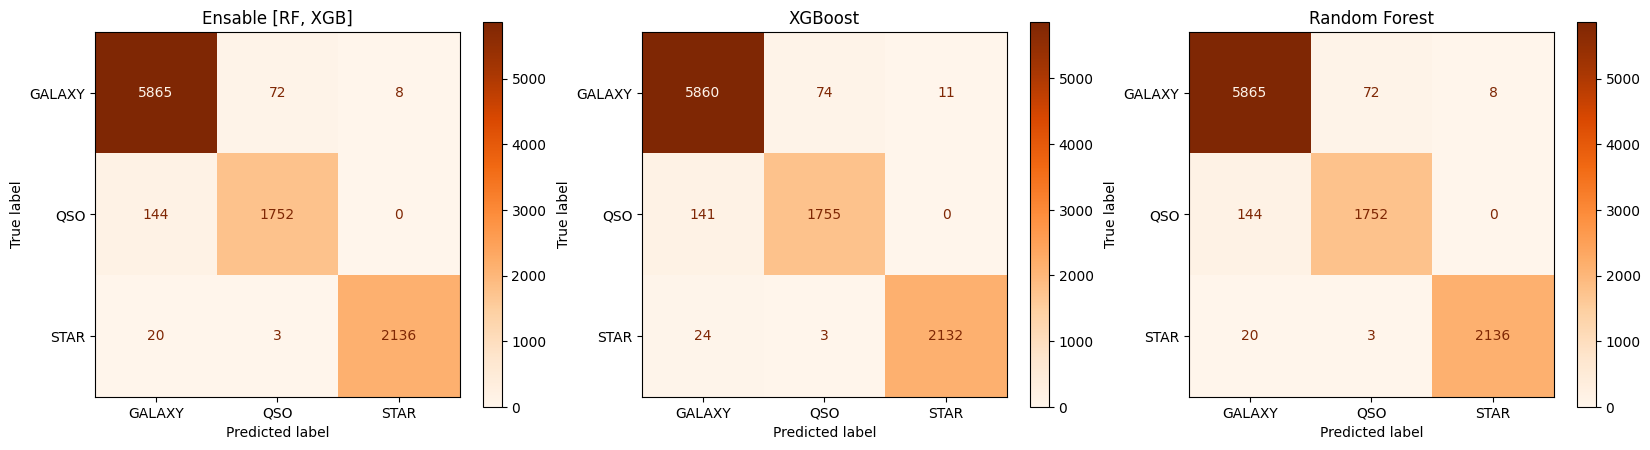

In [93]:
y_pred_ensamble = rf_clf_optimal.predict(X_test)
cf_ensamble= confusion_matrix(y_test_one_dim, y_pred_ensamble)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ConfusionMatrixDisplay(cf_ensamble, display_labels=['GALAXY','QSO','STAR']).plot(cmap='Oranges',ax=ax[0])
ax[0].set_title('Ensable [RF, XGB]')
ConfusionMatrixDisplay(cf_xgb, display_labels=['GALAXY','QSO','STAR']).plot(cmap='Oranges', ax=ax[1])
ax[1].set_title('XGBoost')
ConfusionMatrixDisplay(cf_rf, display_labels=['GALAXY','QSO','STAR']).plot(cmap='Oranges', ax=ax[2])
ax[2].set_title('Random Forest')



The ensamble actually perfomed slighlty better than the two individual models but as expected, it dind't help distinguish QSO/GALAXY. We made it with two classifiers that had an hard time distinguish the two so it was an expected outcome. It could be interesting to build and train a specific classifier that has the sole purpose of classify QSO and GALAXY, and if this classifier actually missclassified less, than our two model we could try to build and ensamble with those trhee, and see if the missclassification actually decreases. (or we could tune further our classifiers, since building a new model to do this binary classication would mean manipolating the data, also the test data, and this is a bad practice) 
But due to time constraint we can't actually explore this route, so instead we will study further this ensamble and see if it is worth the compuational cost, or if we are better off just using the XGboost classifier

In [94]:
train_sizes, train_scores, test_scores = learning_curve(xgb_clf,
                                                       X=X_train_array,
                                                       y=y_train_one_dim,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1_weighted',
                                                       shuffle = False)

(0.95, 1.03)

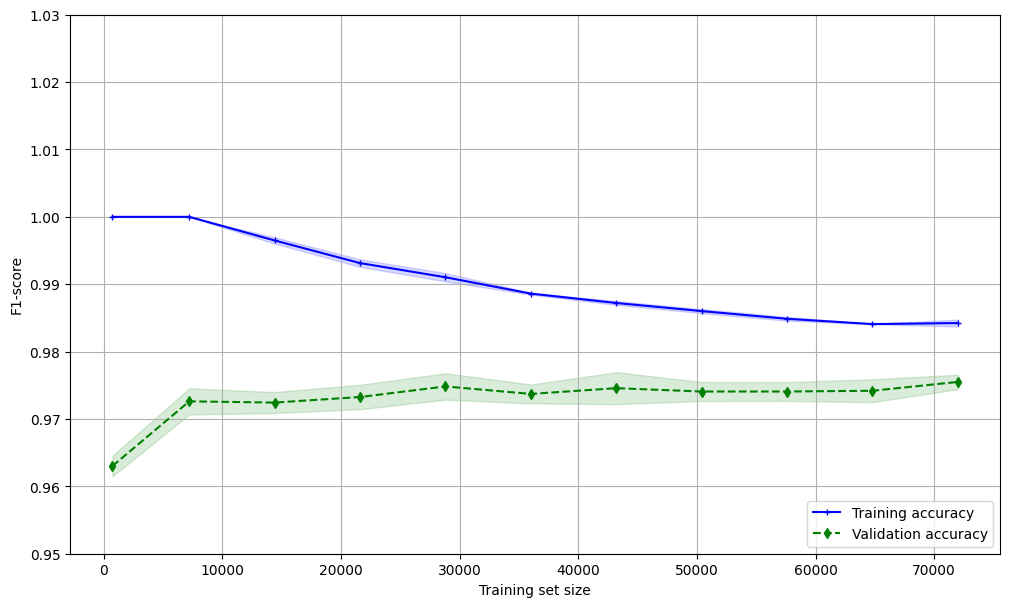

In [95]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.95, 1.03])

The XGBoost present a slight overfittign that is decreasing with the the increasing of the trainign size, this is a good sign. It means that if more data will be collected the model perfomance would probably improve further.

In [96]:
train_sizes, train_scores, test_scores = learning_curve(clf_voting,
                                                       X=X_train_array,
                                                       y=y_train_one_dim,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1_weighted',
                                                       shuffle = False)

(0.96, 1.03)

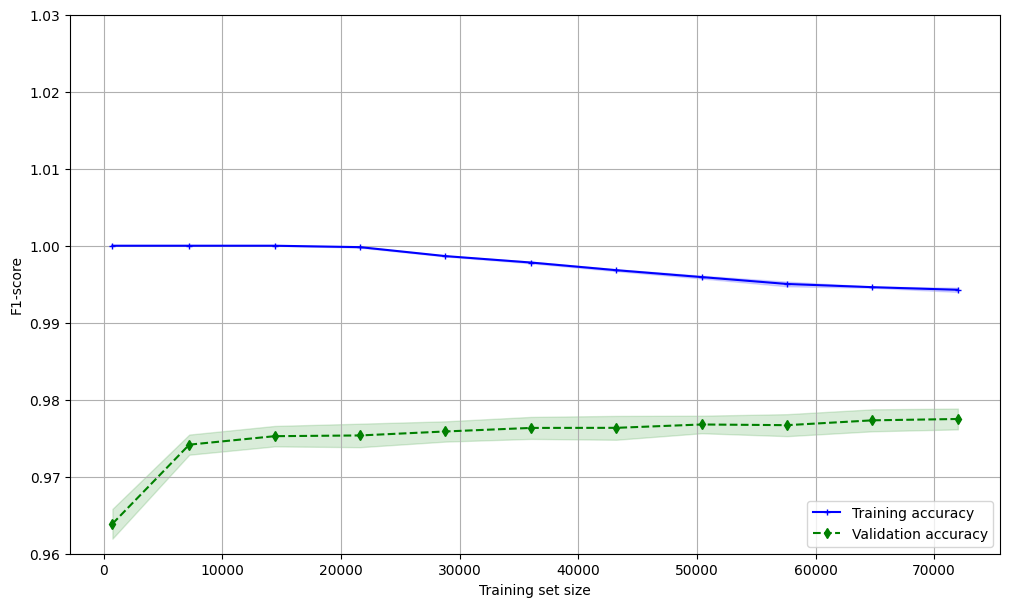

In [97]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.96, 1.03])

We can see that wile dooing a little better than the XGBoost the ensamble[RF,XGB] tend to overfit the data more.

In [105]:
# plot validation curve for the number of estimators
n_estimators_range = list(range(10, 600, 50))
train_scores_xgb, test_scores_xgb = validation_curve(
    xgb_clf_optimal, X_train_array, y_train_one_dim, param_name="n_estimators", param_range=n_estimators_range,
    scoring="f1_weighted", n_jobs=-1, cv=5)


(10.0, 550.0)

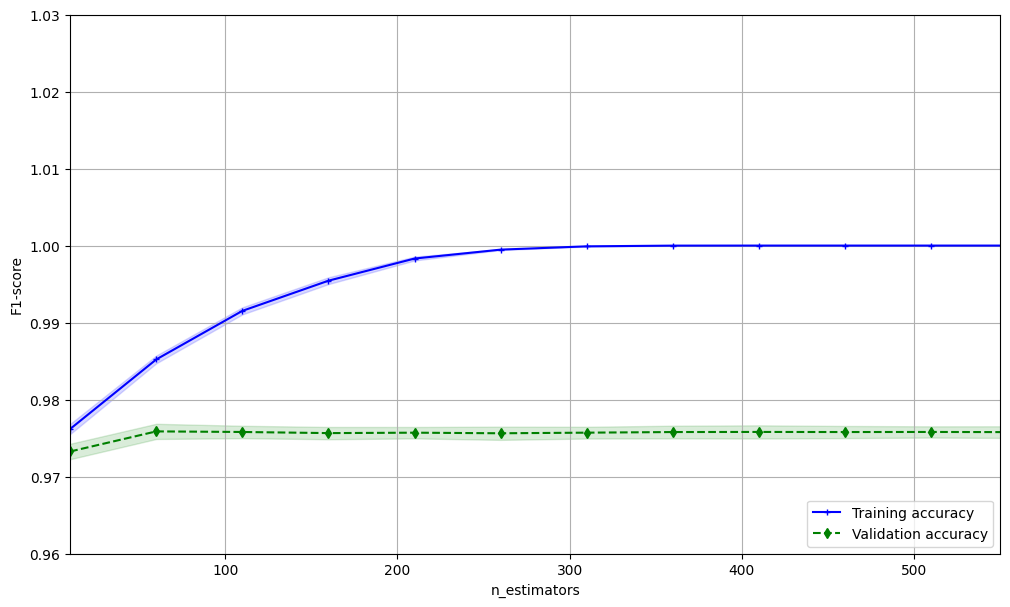

In [108]:
train_mean = np.mean(train_scores_xgb, axis=1)
train_std = np.std(train_scores_xgb, axis=1)
test_mean = np.mean(test_scores_xgb, axis=1)
test_std = np.std(test_scores_xgb, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(n_estimators_range, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(n_estimators_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(n_estimators_range, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(n_estimators_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('n_estimators')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.96, 1.03])
ax.set_xlim([10, 550])

We see that for higher values of n_estimator the overfitting increase while the validation reach a plateau at around 60 exstimator, minimzing the overfitting while maximixing the validation accuracy 

# ROC-AUC

In [122]:
# AUC-ROC
y_pred_xgb = xgb_clf_optimal.predict_proba(X_test)
y_pred_rf = rf_clf_optimal.predict_proba(X_test)
y_pred_ensamble = clf_voting.predict_proba(X_test)

roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb, average='weighted', multi_class='ovr')
roc_auc_rf = roc_auc_score(y_test, y_pred_rf, average='weighted', multi_class='ovr')
roc_auc_ensamble = roc_auc_score(y_test, y_pred_ensamble, average='weighted', multi_class='ovr')




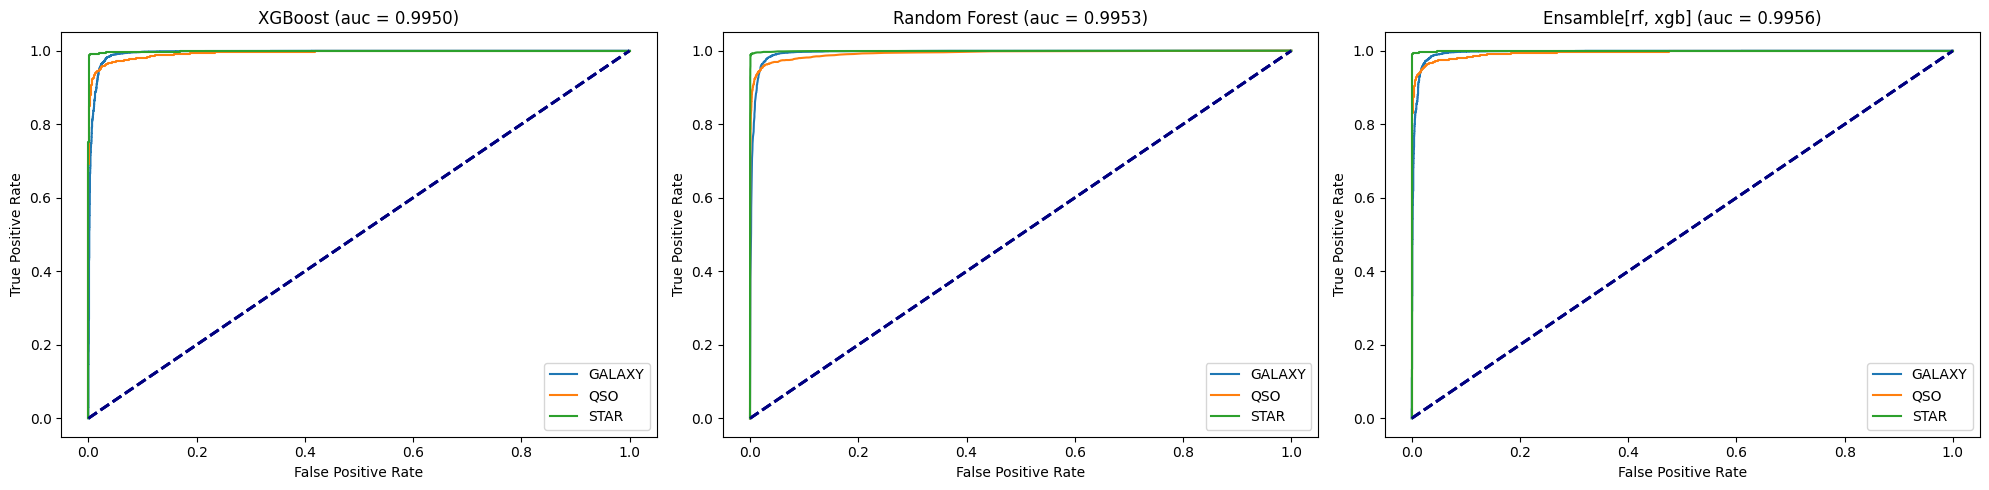

In [123]:
# plot the ROC curve
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
classes = ['GALAXY','QSO','STAR']
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_one_dim, y_pred_xgb[:, i], pos_label=i)
    ax[0].plot(fpr, tpr, label=f'{classes[i]}')
    ax[0].set_title(f'XGBoost (auc = {roc_auc_xgb:.4f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend(loc='lower right')

    fpr, tpr, _ = roc_curve(y_test_one_dim, y_pred_rf[:, i], pos_label=i)
    ax[1].plot(fpr, tpr, label=f'{classes[i]}')
    ax[1].set_title(f'Random Forest (auc = {roc_auc_rf:.4f})')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].legend(loc='lower right')

    fpr, tpr, _ = roc_curve(y_test_one_dim, y_pred_ensamble[:, i], pos_label=i)
    ax[2].plot(fpr, tpr, label=f'{classes[i]}')
    ax[2].set_title(f'Ensamble[rf, xgb] (auc = {roc_auc_ensamble:.4f})')
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].legend(loc='lower right')

    # plot the bisector line
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.tight_layout()
plt.show()

All the models have a really high ROC-AUC score (>0.99) which indicates a great performance of all the algorithms, expecially for the classification of stars where the function is almost a perfect step function. Since for classification performance they are all close to each other we once again prefer the xgboost classifier since its more computationally efficient

## Further look at precision metrics

In [124]:
# print the classification report of the 3 models
labels = ['GALAXY','QSO','STAR']    
print('-'*20 + 'XGBoost' + '-'*20)
y_pred_xgb = xgb_clf_optimal.predict(X_test)
print(classification_report(y_test_one_dim, y_pred_xgb, target_names=labels))


--------------------XGBoost--------------------
              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98      5945
         QSO       0.96      0.93      0.94      1896
        STAR       0.99      0.99      0.99      2159

    accuracy                           0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [125]:
print('-'*20 +'Random Forest' + '-'*20)
y_pred_rf = rf_clf_optimal.predict(X_test)
print(classification_report(y_test_one_dim, y_pred_rf, target_names=labels))

--------------------Random Forest--------------------
              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98      5945
         QSO       0.96      0.92      0.94      1896
        STAR       1.00      0.99      0.99      2159

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000



In [126]:
print('-'*20 + 'Ensamble[rf, xgb]'+ '-'*20)
y_pred_ensamble = clf_voting.predict(X_test)
print(classification_report(y_test_one_dim, y_pred_ensamble, target_names=labels))

--------------------Ensamble[rf, xgb]--------------------
              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98      5945
         QSO       0.96      0.93      0.94      1896
        STAR       1.00      0.99      0.99      2159

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000



Again, all model perform practically the same

# Conclusions and final remarks

This project successfully applied machine learning for multiclass classification of celestial objects. Among the models explored, XGBoost achieved the best performance, highlighting the importance of features like redshift and photometric filters.
The analysis identified challenges like outliers and class imbalance, which could be addressed in future studies with larger datasets and specialized techniques.

## Limitations and possible improvement
- We treated outliers in a very blunt way, using outlier robust classifiers, there are more advanced techniques that would probably allow us to reach an even better performance
- Using the QuntileTrasformer proved to be an effective way to normalize the data, even if doing so we might have lost some of the information regarding outliers. We could have deployed more advanced techniques, but currently those techniques (eg. capping, Winsorizing, isolation forests ) lays beyond the boundary of our ML knowledge, so we prefered to abstain from applying those
- A lack of computational power refrained us to explore more throughtfully the optimization of the classifiers, meaning that the performance could actually be increased further without the need of more data

### The final step
Now as a final and celebrative step we will retrain the best model with all the dataset! In this way we can deliver it to the world confident that we have done everything we could to make the best classifier possible

In [122]:
X_final_step = X.drop(['cam_col', 'fiber_ID', 'obj_ID', 'run_ID'], axis=1)
y_final_step = np.argmax(y, axis=1)
xgb_clf_optimal.fit(X_final_step,y_final_step)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              clf__booster='dart', clf__gamma=0.004640430734934309,
              clf__learning_rate=0.02853415748864355, clf__max_depth=7,
              clf__min_child_weight=16.46890297753569, clf__n_estimators=500,
              clf__reg_alpha=0.2055407080725749,
              clf__reg_lambda=0.26218109692295155, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              dim_reduction=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, ...)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc0aa165-6a8e-4eca-98d5-1e73ce3c12f3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>